In [ ]:
import torch
import os
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm
from matplotlib.pyplot import figure
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.cuda.empty_cache()
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, roc_auc_score
import seaborn as sns
import re

sns.set()
plt.rc('font', family = 'serif')

In [ ]:
def get_binary_testset(dataset_name):
    """
    dataset_name -> trainset, valset, testset
    """
    trainset, valset, testset = None, None, None
    dataset_name = dataset_name.lower()
    path_2_root = "../.."

    if not "oc" in dataset_name:
        if "dar" in dataset_name and "oc" not in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/train_test"
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/validation"

        if "avg" in dataset_name: # Celeb-avg-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_avg"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_avg"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_avg"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_avg"

        elif "rnd" in dataset_name: # Celeb-rnd-30
            if "celeb" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30"
                testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test"
                
            elif "deepfake" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_rnd"
            elif "face2face" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/Face2Face_rnd"
            elif "shift" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceShifter_rnd"
            elif "swap" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/FaceSwap_rnd"
            elif "neural" in dataset_name:
                trainset = f"{path_2_root}/_DATASETS/FF/NeuralTextures_rnd"

        elif "diff" in dataset_name: # Celeb-diff-30
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30"
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30-test"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

        elif "ff" in dataset_name and "deepfake" in dataset_name:
            trainset = f"{path_2_root}/_DATASETS/FF/Deepfakes_avg"

    else: # oc
        if "dar" in dataset_name: # DariusAf_Deepfake_Database
            trainset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/real-train/" # unary
            testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/realfake-test/" # binary

        elif "avg" in dataset_name:
            pass

        elif "rnd" in dataset_name: # Celeb-rnd-30-OC
            trainset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-train/" # unary
            valset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-val/"  # unary
            testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/" # binary

    testset = trainset if testset==None else testset
    valset = trainset if valset==None else valset
    return trainset, valset, testset

In [ ]:
trainset, valset, testset = get_binary_testset("Celeb-rnd") 
dataset_name =  "RND"

In [ ]:
batch_size = 128
epochs = 300
img_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [ ]:
class vae(nn.Module):
    def __init__(self):
        super(vae, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3,stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(32)

        self.fc1 = nn.Linear(25 * 25 * 32, 1000)
        self.fc1_bn = nn.BatchNorm1d(1000)
        self.fc2_mean = nn.Linear(1000, 100)
        self.fc2_logvar = nn.Linear(1000, 100)

        self.fc3 = nn.Linear(100, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        self.fc4 = nn.Linear(1000, 25 * 25 * 32)
        self.fc4_bn = nn.BatchNorm1d(25 * 25 * 32)

        self.relu = nn.ReLU()

        self.conv5 = nn.ConvTranspose2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn6 = nn.BatchNorm2d(32)
        self.conv7 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn7 = nn.BatchNorm2d(16)
        self.conv8 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        
    def encode(self, data):
        conv1 = self.relu(self.bn1(self.conv1(data)))
        conv2 = self.relu(self.bn2(self.conv2(conv1)))
        conv3 = self.relu(self.bn3(self.conv3(conv2)))
        conv4 = self.relu(self.bn4(self.conv4(conv3)))

        fc1 = self.relu(self.fc1_bn(self.fc1(conv4.view(-1, 25 * 25 * 32))))
        mean = self.fc2_mean(fc1)
        logvar = self.fc2_logvar(fc1)
        return mean, logvar
    
    def reparameterize(self, mean, logvar):
        std = 0.5 * torch.exp(logvar)
        z = (std.data.new(std.size()).normal_()) * std + mean
        return z
    
    def decode(self, z):
        fc3 = self.relu(self.fc3_bn(self.fc3(z)))
        fc4 = self.relu(self.fc4_bn(self.fc4(fc3)))
        conv5 = self.relu(self.bn5(self.conv5(fc4.view(-1, 32, 25, 25))))
        conv6 = self.relu(self.bn6(self.conv6(conv5)))
        conv7 = self.relu(self.bn7(self.conv7(conv6)))
        conv8 = self.conv8(conv7)
        return conv8.view(-1, 3, img_size, img_size)
    
    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

def loss_function(recon_x, x, mean, logvar):
    mse_loss = nn.MSELoss(reduction="sum")
    reconstruction_loss = mse_loss(recon_x, x)
    kld_loss = -0.5 * torch.sum(1+logvar-torch.exp(logvar)-mean**2)
    return reconstruction_loss + kld_loss

In [ ]:
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(trainset, 
                         transform=transform_train),
                         batch_size=batch_size, 
                         shuffle=True,
                         drop_last = True)
fakedect = vae().to(device)

num_steps = len(train_loader) * epochs
optimizer = optim.Adam(fakedect.parameters(), lr=1e-4)
print(summary(fakedect, (3, img_size, img_size)))

In [ ]:
history = []

early_stop_coutner = 0
weights_path = f"../../_WEIGHTS/oc_fakedect/OC_FD_e29_l500_AVG.pkl"
fakedect = torch.load(weights_path)

n_dpoints = len(train_loader.dataset)
min_loss = float("inf")
for epoch in range(epochs):#tqdm(range(epochs), total=epochs):
    fakedect.train() # train mode
    train_loss = 0
    for batch_idx, (inputs, _) in tqdm(enumerate(train_loader), total=n_dpoints//batch_size-1):
        inputs = inputs.to(device)
        gen_imgs, mean, logvar = fakedect(inputs)
        loss = loss_function(gen_imgs, inputs, mean, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    L = train_loss / n_dpoints
    history += [L]
    print(f"Epoch={epoch}\tloss={L:.4f}")
    if L < min_loss:
        min_loss = L
        torch.save(fakedect, f"../../_WEIGHTS/oc_fakedect/OC_FD_e{epoch+1}_l{int(L)}_{dataset_name}.pkl")
        print(f"../../_WEIGHTS/oc_fakedect/OC_FD_e{epoch+1}_l{int(L)}_{dataset_name}.pkl")
        early_stop_coutner = 0
    else:
        early_stop_coutner += 1
    
    if early_stop_coutner>20:
        break

In [ ]:
# load best weights for eval
# weights_path = "../../_WEIGHTS/oc_fakedect/OC_FD_e29_l500_AVG.pkl"
# weights_path = "../../_WEIGHTS/oc_fakedect/OC_FD_e2_l532_RND.pkl"

# weights_path = "../../_WEIGHTS/oc_fakedect/OC_FD_e204_l1429_DFDB.pkl"
# weights_path = "../../_WEIGHTS/oc_fakedect/OC_FD_e1_l1431_DFDB.pkl"
fakedect = torch.load(weights_path)

In [ ]:
fig, ax = plt.subplots(1, figsize = (10, 10), sharex=True)
ax.plot(history)
ax.set_title(f'OC-FakeDect1 {dataset_name} Training/Validation Losses')
ax.set_ylabel('Loss')
ax.legend(['Training Loss'], loc='center right')
plt.savefig(f"./Results/{dataset_name}_Losses.pdf", dpi=fig.dpi)
plt.show()

In [ ]:
# shwcse_img_path = "D:/MInf/Datasets/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/Celeb-real/id11_0009_1.png"
# img = cv2.cvtColor(cv2.imread(shwcse_img_path), cv2.COLOR_BGR2RGB)
# image = transform_test(img)
# image = image.float().to(device)
# # print(image.shape)
# # fakedect = torch.load(weights_path)
# fakedect.eval()
# with torch.no_grad():
#     x = image.view(-1,3,100,100)
#     print(x.shape)
#     decode_z, mean_z, logvar_z = fakedect(x)
#     # print(decode_z.shape )
# decode_z = decode_z.view(3,100,100).cpu()
# decode_z = 255*(decode_z*0.5 + 0.5).numpy()
# decode_z = decode_z.astype(int)
# plt.subplot(1,2,1)
# plt.imshow(img)
# plt.subplot(1,2,2)
# plt.imshow(decode_z.transpose(1,2,0))

In [ ]:
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

In [ ]:
#               # experiment_name,                                       model_name,          testset_name,                 fname
# EXPERIMENTS = [

#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                \nTested on DFDB Dataset",  f"OC-FakeDect1_{dataset_name}", "DariusAf_Deepfake_Database", f"OC-FakeDect1_{dataset_name}_onDFDB"),

#                 # OC-FakeDect1 RND on Celebs indep eval
#                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                \nTested on AVG CDFv2 Dataset",  f"OC-FakeDect1_{dataset_name}", "Celeb-avg-30", f"OC-FakeDect1_{dataset_name}_onAVG"),

#                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                \nTested on RND CDFv2 Dataset",  f"OC-FakeDect1_{dataset_name}", "Celeb-rnd-30", f"OC-FakeDect1_{dataset_name}_onRND"),

#                 # OC-FakeDect1 RND on Celebs rae
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                \nTested on AVG CDFv2 Dataset\
#                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Celeb-avg-30", f"OC-FakeDect1_{dataset_name}_raeonAVG"),

#                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                \nTested on RND CDFv2 Dataset\
#                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Celeb-rnd-30", f"OC-FakeDect1_{dataset_name}_raeonRND"),

#                 # OC-FakeDect1 RND on FF indep eval
#                 # DF
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                \nTested on AVG Deepfakes Dataset\
#                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_avg", f"OC-FakeDect1_{dataset_name}_raeonDFavg"),
             
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                \nTested on AVG Deepfakes Dataset",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_avg", f"OC-FakeDect1_{dataset_name}_DFavg"),
             
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                \nTested on RND Deepfakes Dataset\
#                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_rnd", f"OC-FakeDect1_{dataset_name}_raeonDFrnd"),
             
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                \nTested on RND Deepfakes Dataset",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_rnd", f"OC-FakeDect1_{dataset_name}_DFrnd"),

#                 # F2F
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on AVG Face2Face Dataset\
#                 \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Face2Face_avg", f"OC-FakeDect1_{dataset_name}_raeonF2Favg"),
             
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on AVG Face2Face Dataset",  f"OC-FakeDect1_{dataset_name}", "Face2Face_avg", f"OC-FakeDect1_{dataset_name}_F2Favg"),
              
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on RND Face2Face Dataset\
#                 \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Face2Face_rnd", f"OC-FakeDect1_{dataset_name}_raeonF2Frnd"),
               
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on RND Face2Face Dataset",  f"OC-FakeDect1_{dataset_name}", "Face2Face_rnd", f"OC-FakeDect1_{dataset_name}_F2Frnd"),

#                 # FaceShifter
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on AVG FaceShifter Dataset\
#                 \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_avg", f"OC-FakeDect1_{dataset_name}_raeonFSHFTavg"),
                
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on AVG FaceShifter Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_avg", f"OC-FakeDect1_{dataset_name}_FSHFTavg"),
               
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on RND FaceShifter Dataset\
#                 \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_rnd", f"OC-FakeDect1_{dataset_name}_raeonFSHFTrnd"),
                
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on RND FaceShifter Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_rnd", f"OC-FakeDect1_{dataset_name}_FSHFTrnd"),

#                 # FaceSwap
                
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on AVG FaceSwap Dataset\
#                 \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_avg", f"OC-FakeDect1_{dataset_name}_raeonFSavg"),
                
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on AVG FaceSwap Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_avg", f"OC-FakeDect1_{dataset_name}_FSavg"),
                
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on RND FaceSwap Dataset\
#                 \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_rnd", f"OC-FakeDect1_{dataset_name}_raeonFSrnd"),
                
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on RND FaceSwap Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_rnd", f"OC-FakeDect1_{dataset_name}_FSrnd"),

#                 # NeuralTextures
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on AVG NeuralTextures Dataset\
#                 \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_avg", f"OC-FakeDect1_{dataset_name}_raeonNTavg"),
                
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on AVG NeuralTextures Dataset",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_avg", f"OC-FakeDect1_{dataset_name}_NTavg"),
                
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on RND NeuralTextures Dataset\
#                 \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_rnd", f"OC-FakeDect1_{dataset_name}_raeonNTrnd"),
                
#                 (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
#                 \nTested on RND NeuralTextures Dataset",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_rnd", f"OC-FakeDect1_{dataset_name}_NTrnd"),
#                ]

'OC-FakeDect1 (Trained on DFDB Dataset)               
Tested on DFDB Dataset'
OC-FakeDect1_DFDB
DariusAf_Deepfake_Database
../../_DATASETS/DariusAf_Deepfake_Database/validation
OC-FakeDect1_DFDB_onDFDB




100%|██████████| 18038/18038 [01:03<00:00, 282.14it/s]


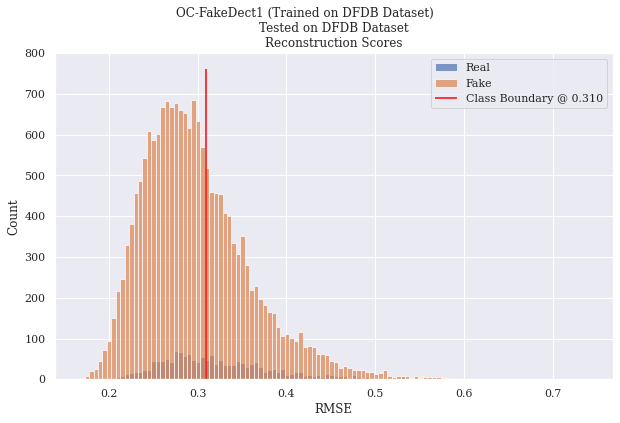

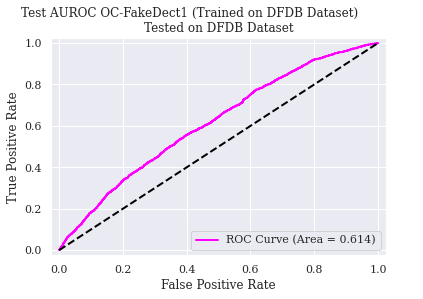

'OC-FakeDect1 (Trained on DFDB Dataset)               
Tested on AVG CDFv2 Dataset'
OC-FakeDect1_DFDB
Celeb-avg-30
../../_DATASETS/Celeb-DF-v2/Celeb-avg-30-test
OC-FakeDect1_DFDB_onAVG




100%|██████████| 18038/18038 [01:04<00:00, 277.86it/s]


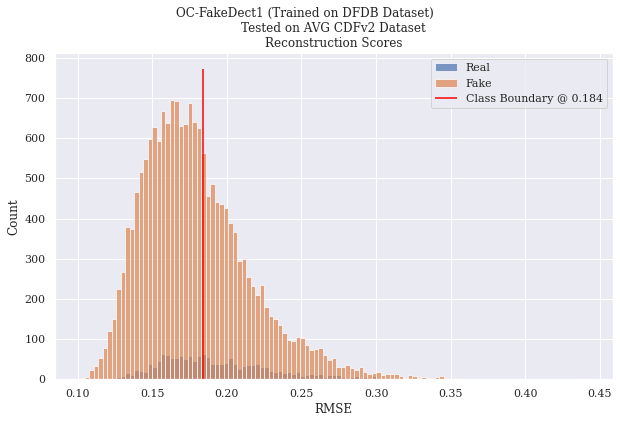

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


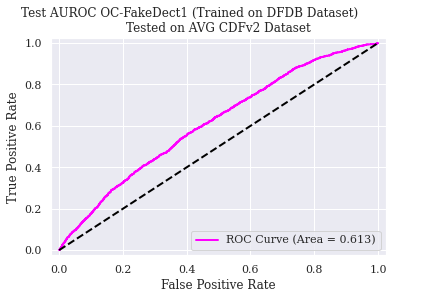

'OC-FakeDect1 (Trained on DFDB Dataset)               
Tested on RND CDFv2 Dataset'
OC-FakeDect1_DFDB
Celeb-rnd-30
../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test
OC-FakeDect1_DFDB_onRND




100%|██████████| 18038/18038 [01:05<00:00, 275.56it/s]


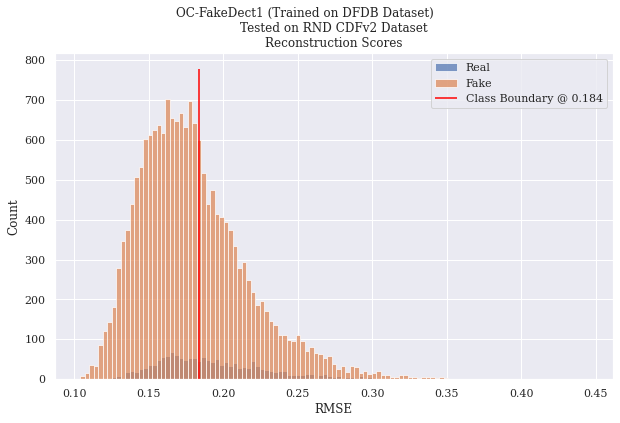

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


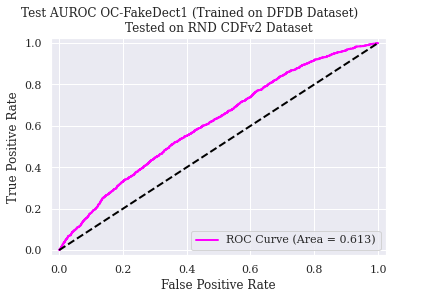

'OC-FakeDect1 (Trained on DFDB Dataset)               
Tested on AVG CDFv2 Dataset               
Running Average Evaluation'
OC-FakeDect1_DFDB
Celeb-avg-30
../../_DATASETS/Celeb-DF-v2/Celeb-avg-30-test
OC-FakeDect1_DFDB_raeonAVG




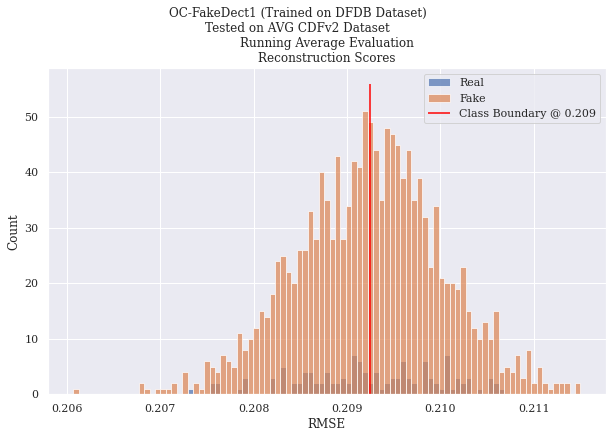

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


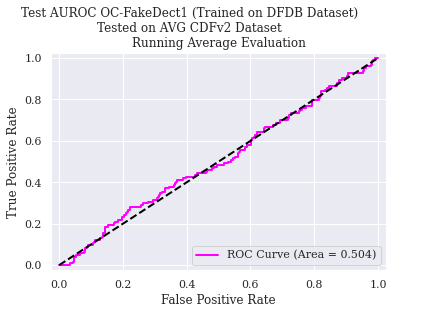

'OC-FakeDect1 (Trained on DFDB Dataset)               
Tested on RND CDFv2 Dataset               
Running Average Evaluation'
OC-FakeDect1_DFDB
Celeb-rnd-30
../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test
OC-FakeDect1_DFDB_raeonRND




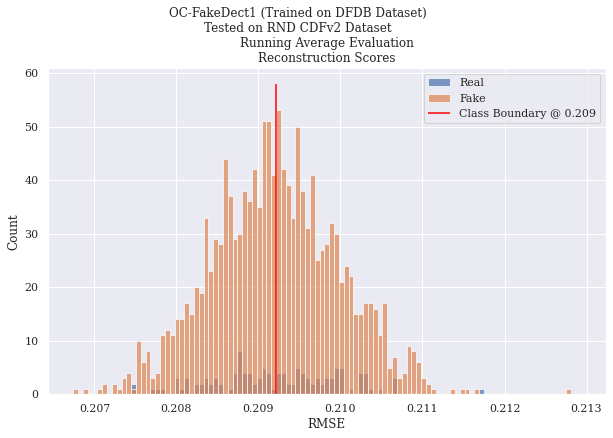

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


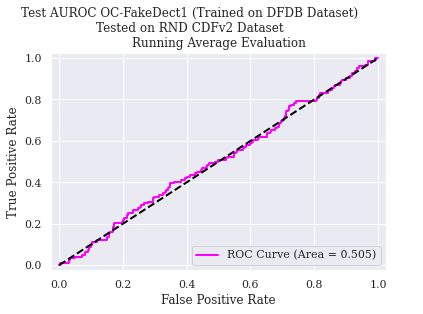

'OC-FakeDect1 (Trained on DFDB Dataset)               
Tested on AVG Deepfakes Dataset               
Running Average Evaluation'
OC-FakeDect1_DFDB
Deepfakes_avg
../../_DATASETS/FF/Deepfakes_avg
OC-FakeDect1_DFDB_raeonDFavg




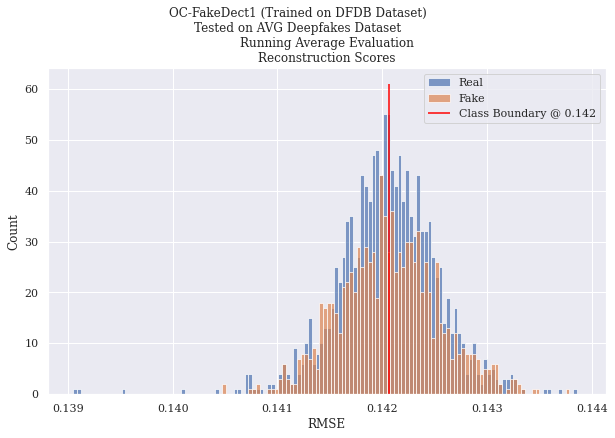

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


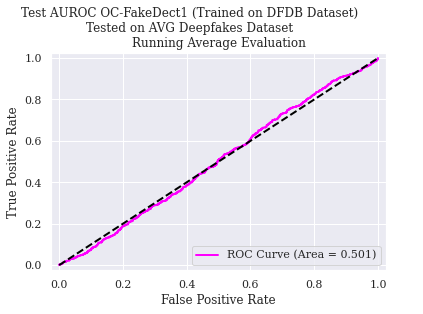

'OC-FakeDect1 (Trained on DFDB Dataset)               
Tested on AVG Deepfakes Dataset'
OC-FakeDect1_DFDB
Deepfakes_avg
../../_DATASETS/FF/Deepfakes_avg
OC-FakeDect1_DFDB_DFavg




100%|██████████| 18038/18038 [01:01<00:00, 292.64it/s]


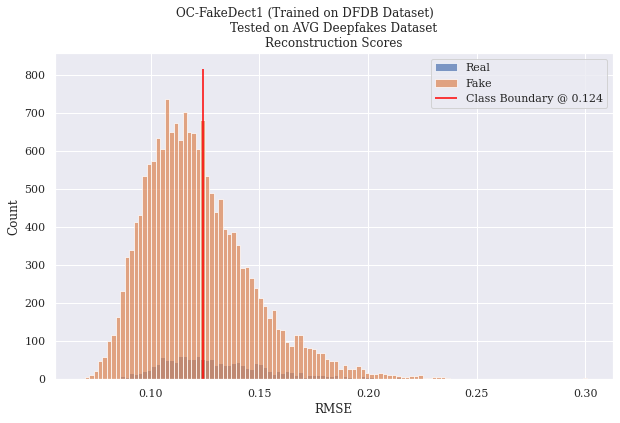

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


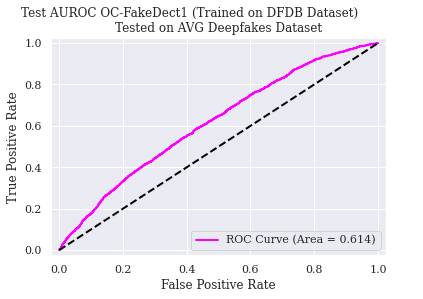

'OC-FakeDect1 (Trained on DFDB Dataset)               
Tested on RND Deepfakes Dataset               
Running Average Evaluation'
OC-FakeDect1_DFDB
Deepfakes_rnd
../../_DATASETS/FF/Deepfakes_rnd
OC-FakeDect1_DFDB_raeonDFrnd




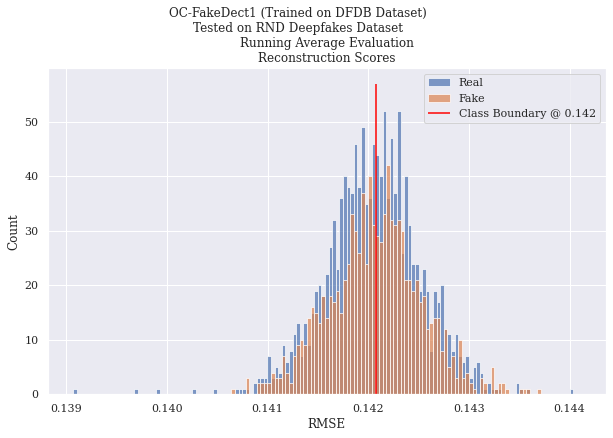

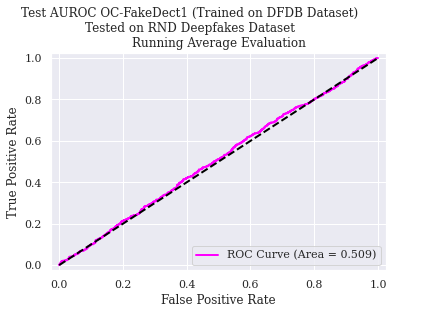

'OC-FakeDect1 (Trained on DFDB Dataset)               
Tested on RND Deepfakes Dataset'
OC-FakeDect1_DFDB
Deepfakes_rnd
../../_DATASETS/FF/Deepfakes_rnd
OC-FakeDect1_DFDB_DFrnd




100%|██████████| 18038/18038 [01:01<00:00, 291.02it/s]


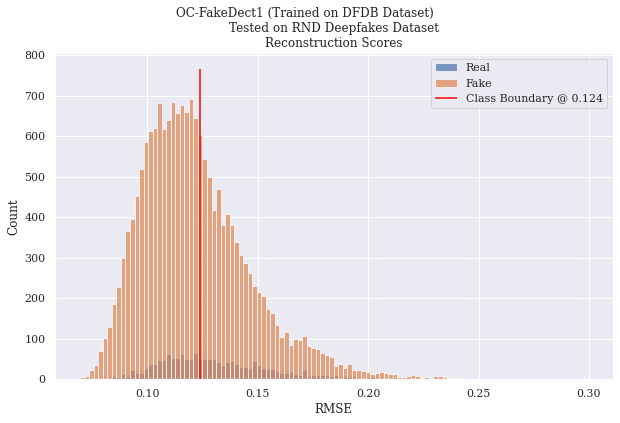

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


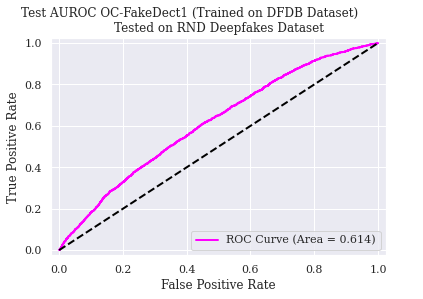

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on AVG Face2Face Dataset                
Running Average Evaluation'
OC-FakeDect1_DFDB
Face2Face_avg
../../_DATASETS/FF/Face2Face_avg
OC-FakeDect1_DFDB_raeonF2Favg




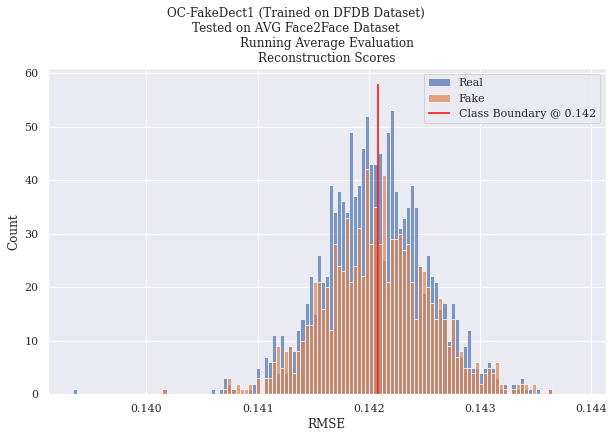

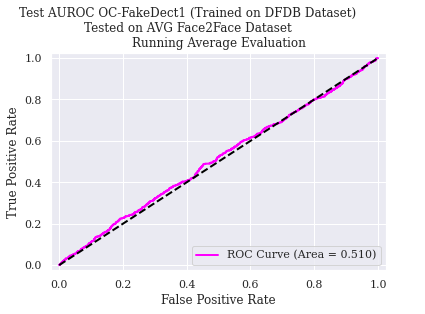

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on AVG Face2Face Dataset'
OC-FakeDect1_DFDB
Face2Face_avg
../../_DATASETS/FF/Face2Face_avg
OC-FakeDect1_DFDB_F2Favg




100%|██████████| 18038/18038 [01:02<00:00, 288.77it/s]


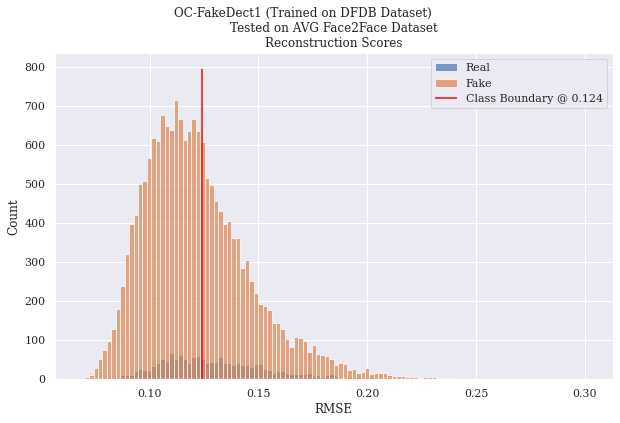

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


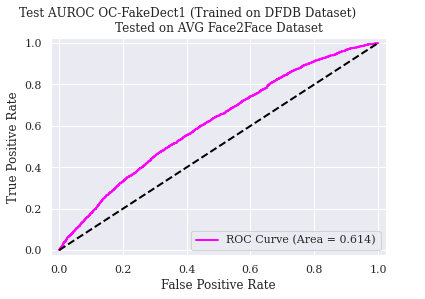

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on RND Face2Face Dataset                
Running Average Evaluation'
OC-FakeDect1_DFDB
Face2Face_rnd
../../_DATASETS/FF/Face2Face_rnd
OC-FakeDect1_DFDB_raeonF2Frnd




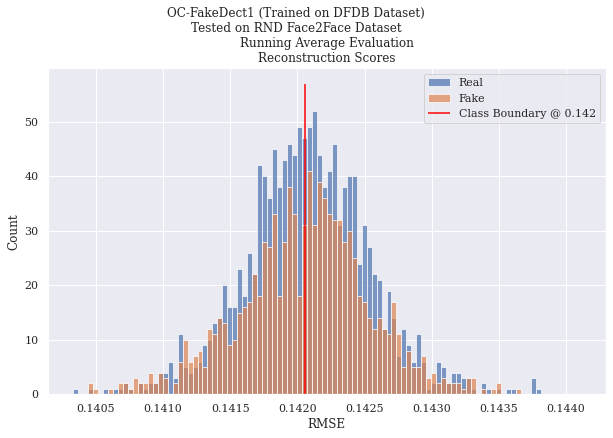

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


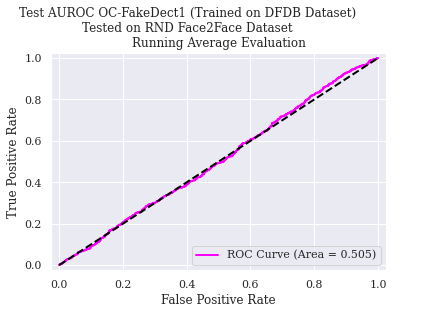

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on RND Face2Face Dataset'
OC-FakeDect1_DFDB
Face2Face_rnd
../../_DATASETS/FF/Face2Face_rnd
OC-FakeDect1_DFDB_F2Frnd




100%|██████████| 18038/18038 [01:03<00:00, 282.35it/s]


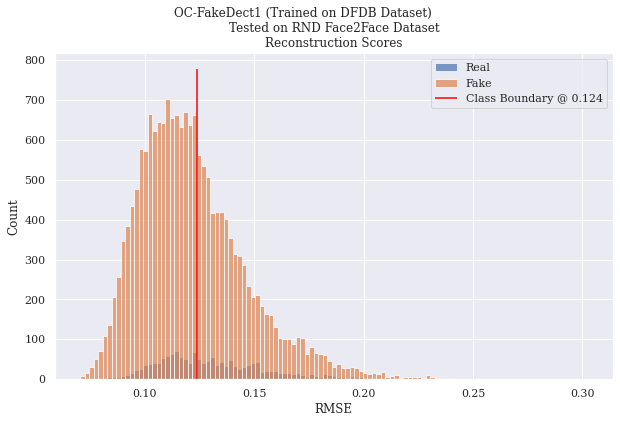

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


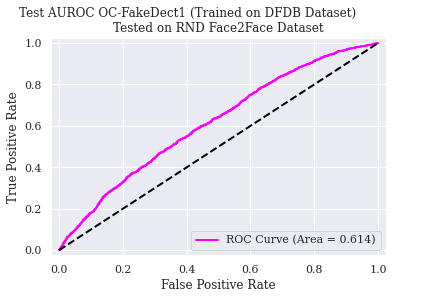

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on AVG FaceShifter Dataset                
Running Average Evaluation'
OC-FakeDect1_DFDB
FaceShifter_avg
../../_DATASETS/FF/FaceShifter_avg
OC-FakeDect1_DFDB_raeonFSHFTavg




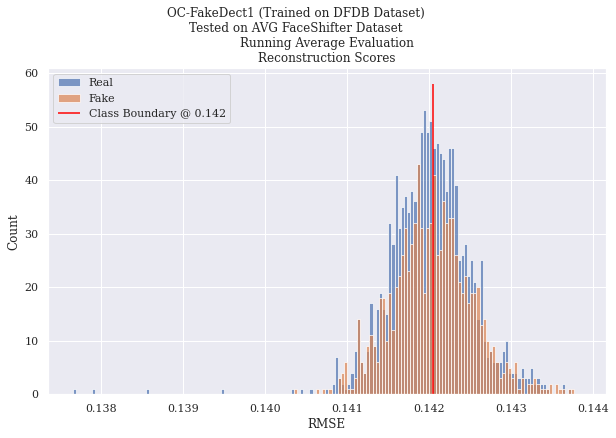

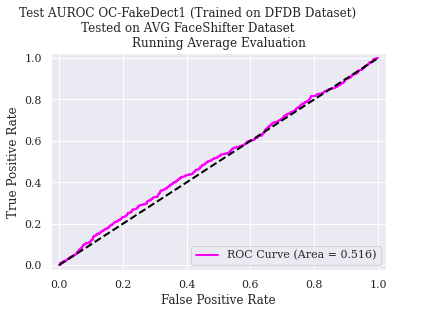

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on AVG FaceShifter Dataset'
OC-FakeDect1_DFDB
FaceShifter_avg
../../_DATASETS/FF/FaceShifter_avg
OC-FakeDect1_DFDB_FSHFTavg




100%|██████████| 18038/18038 [01:06<00:00, 271.04it/s]


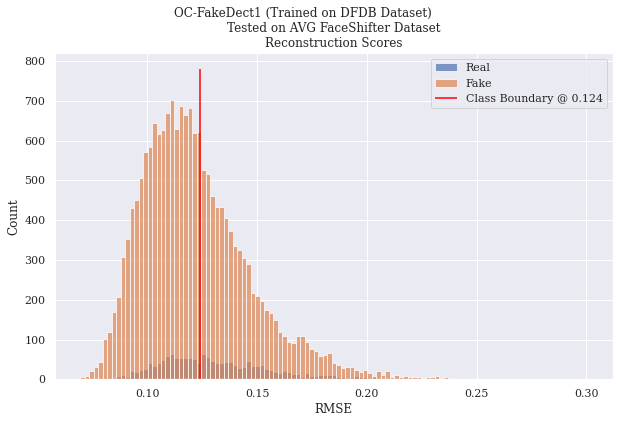

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


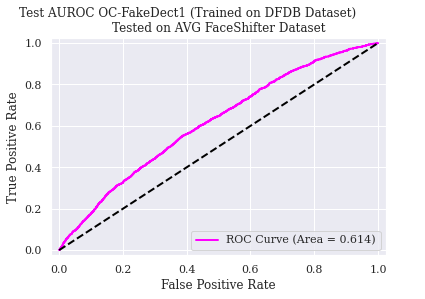

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on RND FaceShifter Dataset                
Running Average Evaluation'
OC-FakeDect1_DFDB
FaceShifter_rnd
../../_DATASETS/FF/FaceShifter_rnd
OC-FakeDect1_DFDB_raeonFSHFTrnd




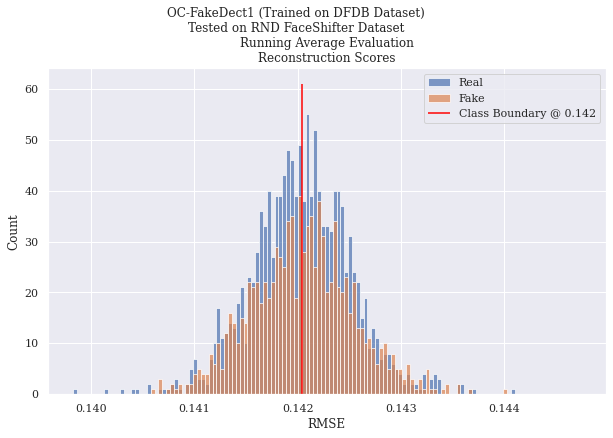

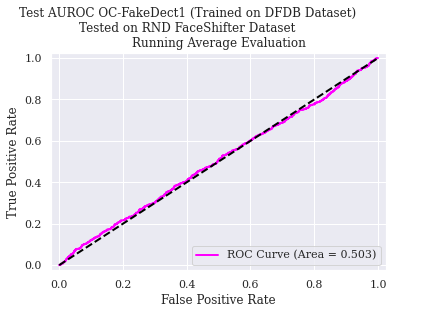

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on RND FaceShifter Dataset'
OC-FakeDect1_DFDB
FaceShifter_rnd
../../_DATASETS/FF/FaceShifter_rnd
OC-FakeDect1_DFDB_FSHFTrnd




100%|██████████| 18038/18038 [02:10<00:00, 137.79it/s]


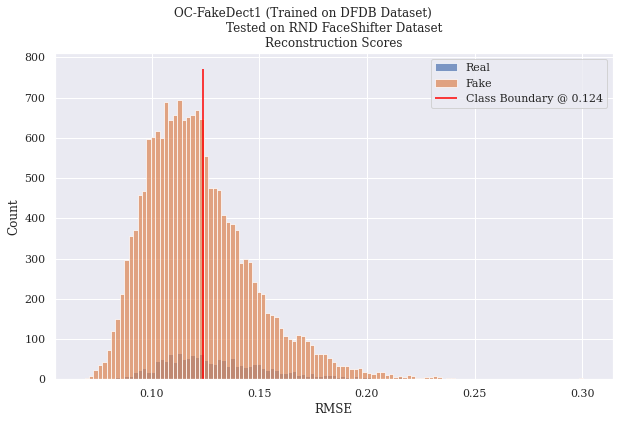

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


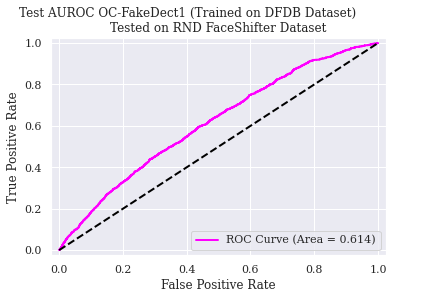

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on AVG FaceSwap Dataset                
Running Average Evaluation'
OC-FakeDect1_DFDB
FaceSwap_avg
../../_DATASETS/FF/FaceSwap_avg
OC-FakeDect1_DFDB_raeonFSavg




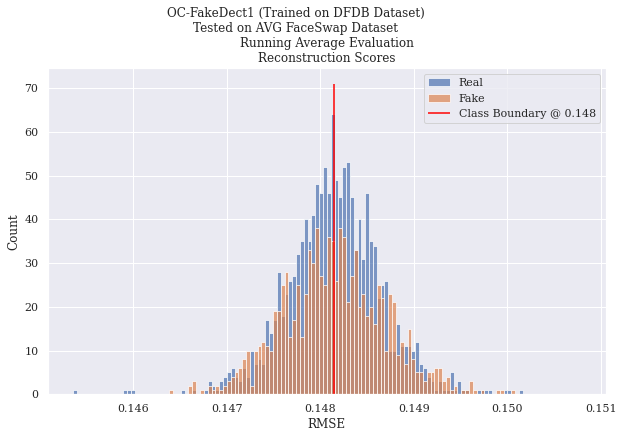

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


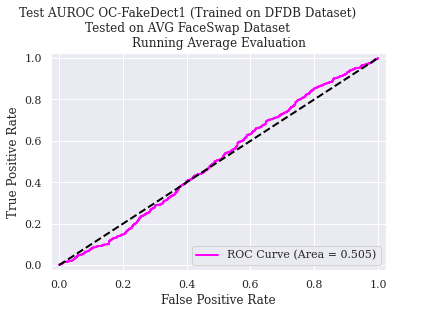

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on AVG FaceSwap Dataset'
OC-FakeDect1_DFDB
FaceSwap_avg
../../_DATASETS/FF/FaceSwap_avg
OC-FakeDect1_DFDB_FSavg




100%|██████████| 18038/18038 [01:12<00:00, 248.01it/s]


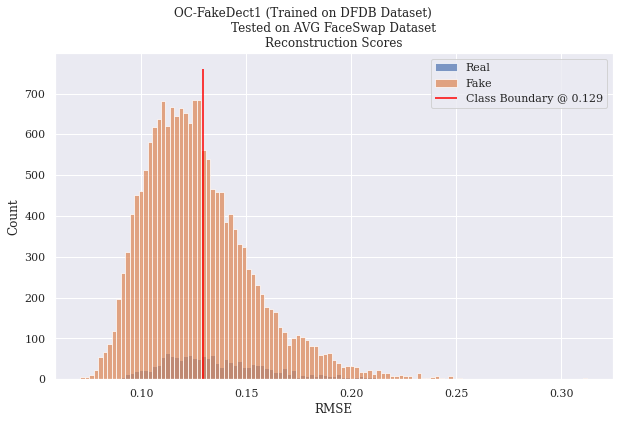

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


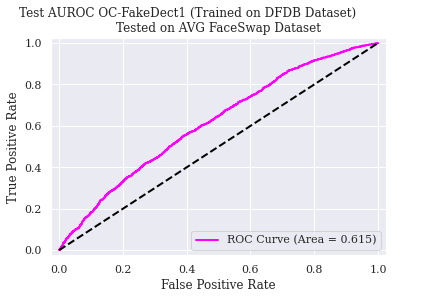

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on RND FaceSwap Dataset                
Running Average Evaluation'
OC-FakeDect1_DFDB
FaceSwap_rnd
../../_DATASETS/FF/FaceSwap_rnd
OC-FakeDect1_DFDB_raeonFSrnd




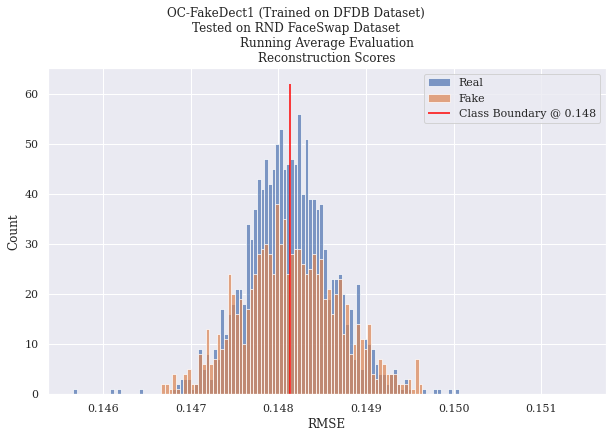

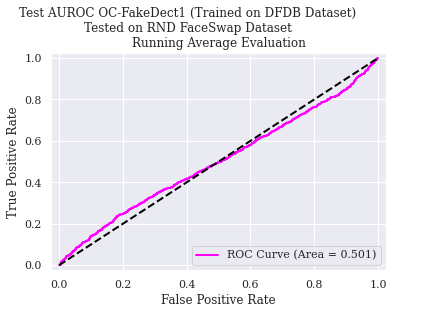

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on RND FaceSwap Dataset'
OC-FakeDect1_DFDB
FaceSwap_rnd
../../_DATASETS/FF/FaceSwap_rnd
OC-FakeDect1_DFDB_FSrnd




100%|██████████| 18038/18038 [01:55<00:00, 155.91it/s]


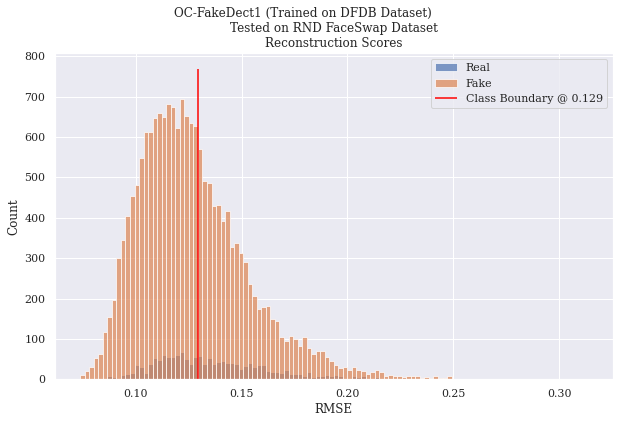

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


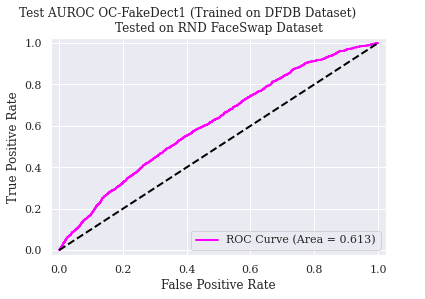

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on AVG NeuralTextures Dataset                
Running Average Evaluation'
OC-FakeDect1_DFDB
NeuralTextures_avg
../../_DATASETS/FF/NeuralTextures_avg
OC-FakeDect1_DFDB_raeonNTavg




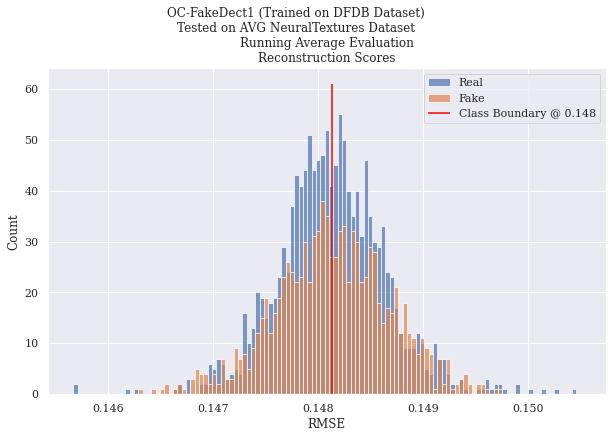

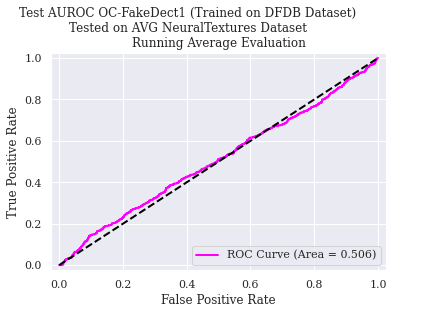

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on AVG NeuralTextures Dataset'
OC-FakeDect1_DFDB
NeuralTextures_avg
../../_DATASETS/FF/NeuralTextures_avg
OC-FakeDect1_DFDB_NTavg




100%|██████████| 18038/18038 [01:33<00:00, 192.55it/s]


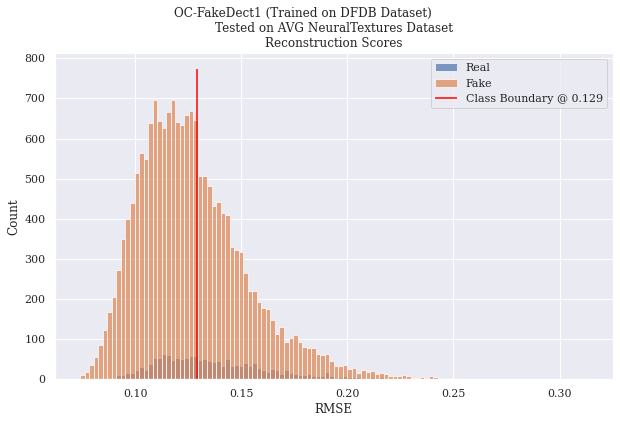

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


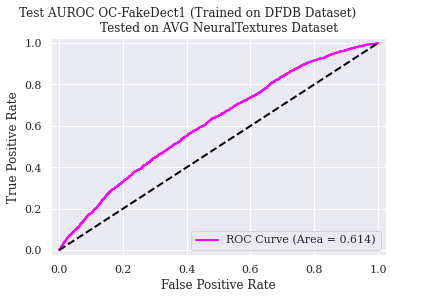

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on RND NeuralTextures Dataset                
Running Average Evaluation'
OC-FakeDect1_DFDB
NeuralTextures_rnd
../../_DATASETS/FF/NeuralTextures_rnd
OC-FakeDect1_DFDB_raeonNTrnd




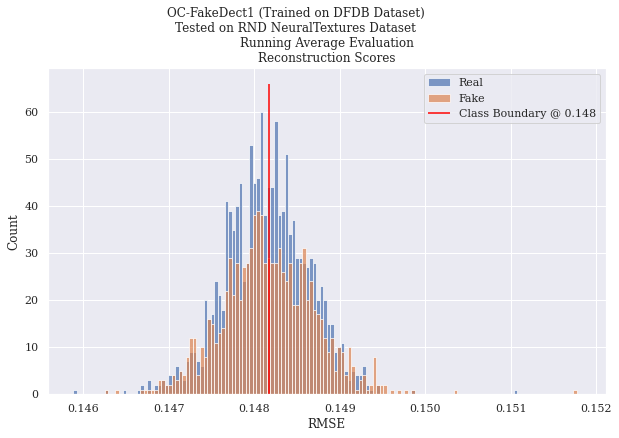

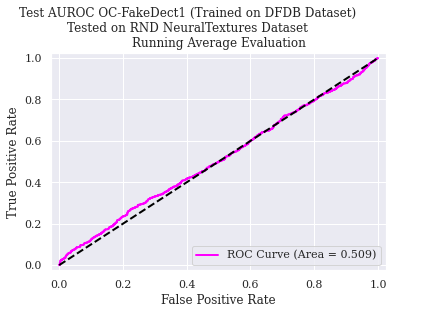

'OC-FakeDect1 (Trained on DFDB Dataset)                
Tested on RND NeuralTextures Dataset'
OC-FakeDect1_DFDB
NeuralTextures_rnd
../../_DATASETS/FF/NeuralTextures_rnd
OC-FakeDect1_DFDB_NTrnd




100%|██████████| 18038/18038 [01:01<00:00, 292.28it/s]


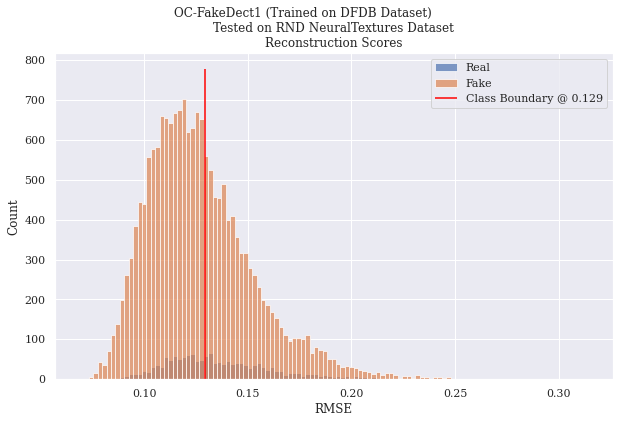

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


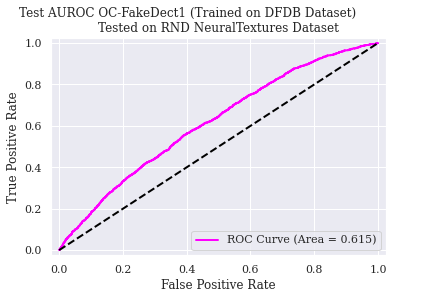

'OC-FakeDect1 (Trained on AVG Dataset)               
Tested on DFDB Dataset'
OC-FakeDect1_AVG
DariusAf_Deepfake_Database
../../_DATASETS/DariusAf_Deepfake_Database/validation
OC-FakeDect1_AVG_onDFDB




100%|██████████| 18038/18038 [01:01<00:00, 292.31it/s]


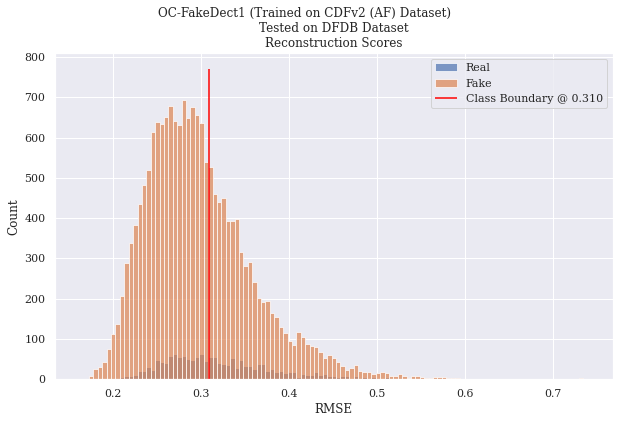

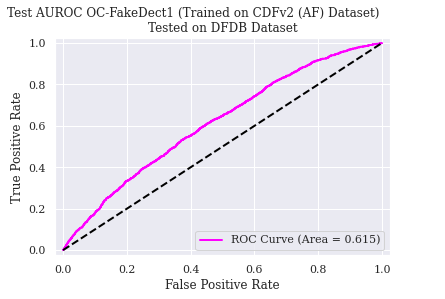

'OC-FakeDect1 (Trained on AVG Dataset)               
Tested on AVG CDFv2 Dataset'
OC-FakeDect1_AVG
Celeb-avg-30
../../_DATASETS/Celeb-DF-v2/Celeb-avg-30-test
OC-FakeDect1_AVG_onAVG




100%|██████████| 18038/18038 [01:01<00:00, 291.89it/s]


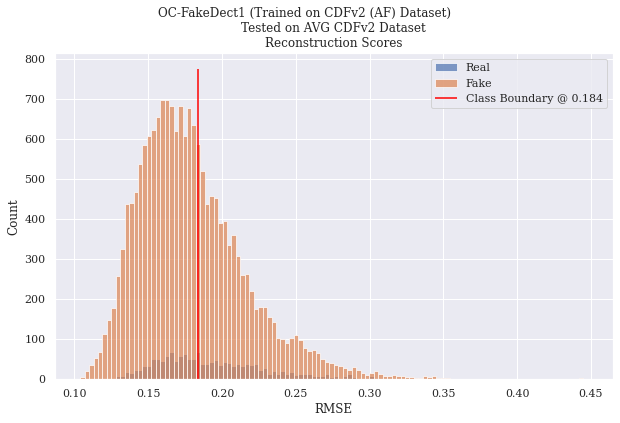

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


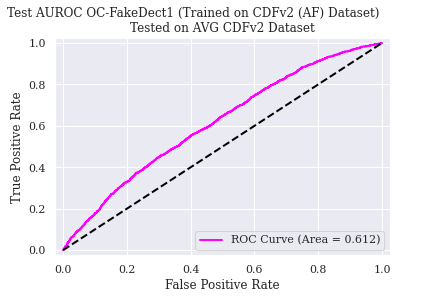

'OC-FakeDect1 (Trained on AVG Dataset)               
Tested on RND CDFv2 Dataset'
OC-FakeDect1_AVG
Celeb-rnd-30
../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test
OC-FakeDect1_AVG_onRND




100%|██████████| 18038/18038 [01:02<00:00, 286.72it/s]


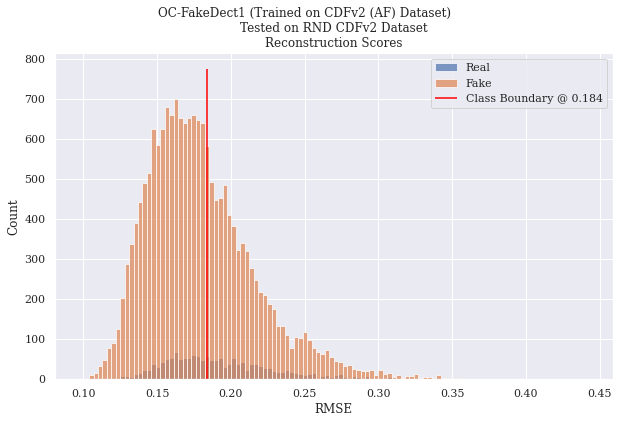

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


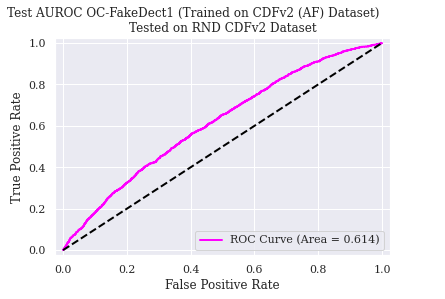

'OC-FakeDect1 (Trained on AVG Dataset)               
Tested on AVG CDFv2 Dataset               
Running Average Evaluation'
OC-FakeDect1_AVG
Celeb-avg-30
../../_DATASETS/Celeb-DF-v2/Celeb-avg-30-test
OC-FakeDect1_AVG_raeonAVG




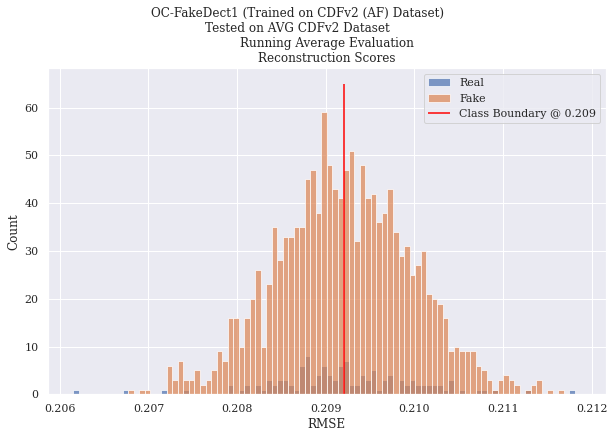

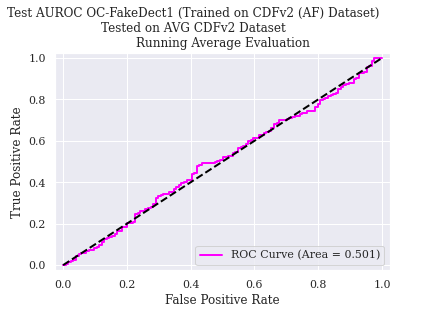

'OC-FakeDect1 (Trained on AVG Dataset)               
Tested on RND CDFv2 Dataset               
Running Average Evaluation'
OC-FakeDect1_AVG
Celeb-rnd-30
../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test
OC-FakeDect1_AVG_raeonRND




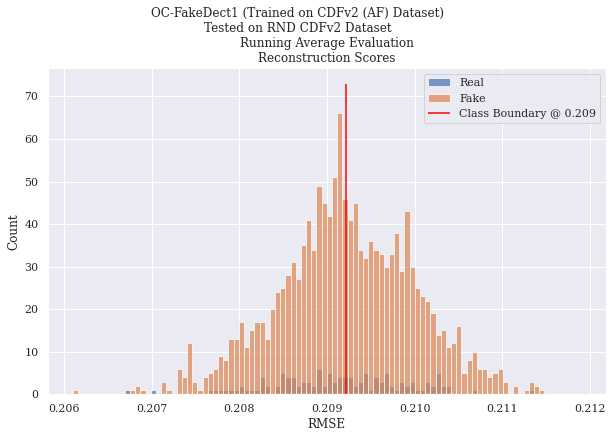

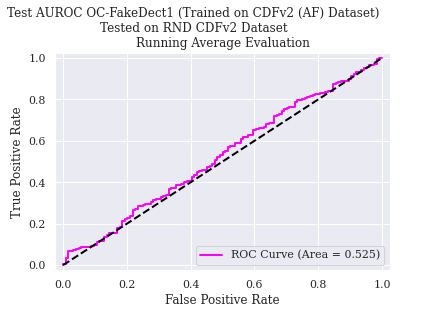

'OC-FakeDect1 (Trained on AVG Dataset)               
Tested on AVG Deepfakes Dataset               
Running Average Evaluation'
OC-FakeDect1_AVG
Deepfakes_avg
../../_DATASETS/FF/Deepfakes_avg
OC-FakeDect1_AVG_raeonDFavg




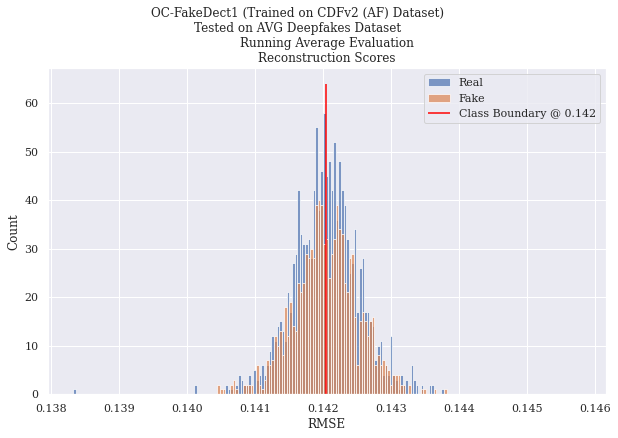

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


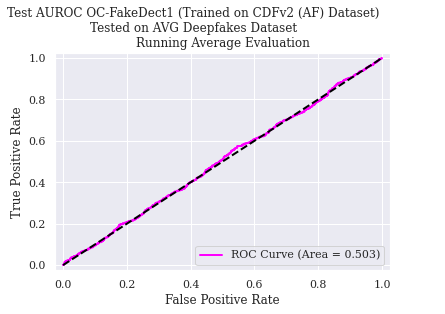

'OC-FakeDect1 (Trained on AVG Dataset)               
Tested on AVG Deepfakes Dataset'
OC-FakeDect1_AVG
Deepfakes_avg
../../_DATASETS/FF/Deepfakes_avg
OC-FakeDect1_AVG_DFavg




100%|██████████| 18038/18038 [01:01<00:00, 293.23it/s]


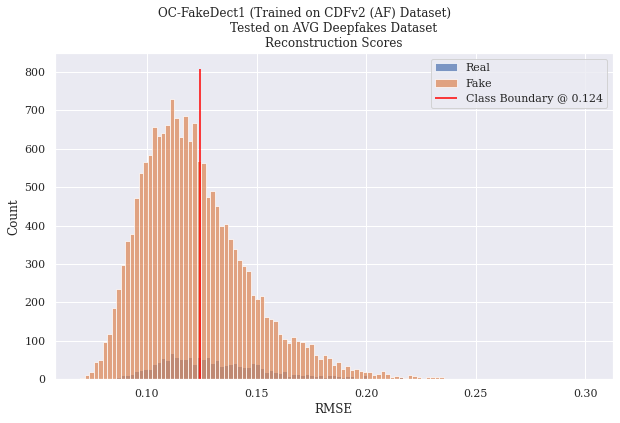

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


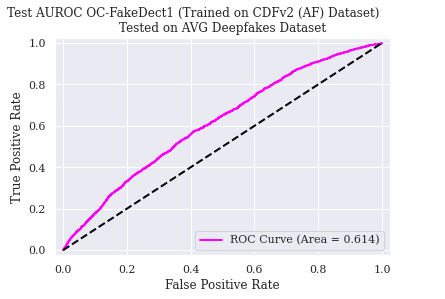

'OC-FakeDect1 (Trained on AVG Dataset)               
Tested on RND Deepfakes Dataset               
Running Average Evaluation'
OC-FakeDect1_AVG
Deepfakes_rnd
../../_DATASETS/FF/Deepfakes_rnd
OC-FakeDect1_AVG_raeonDFrnd




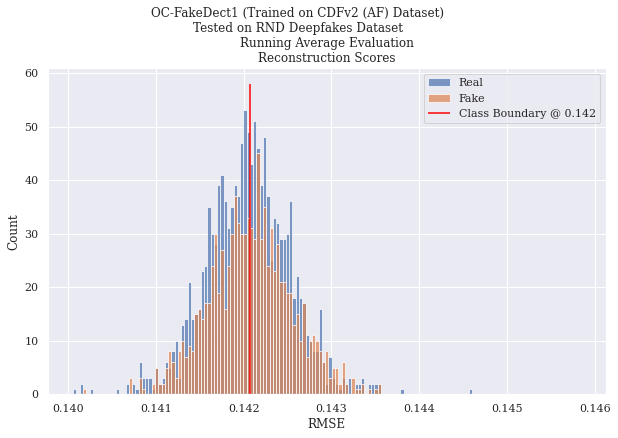

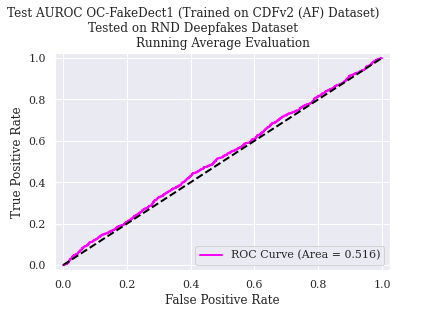

'OC-FakeDect1 (Trained on AVG Dataset)               
Tested on RND Deepfakes Dataset'
OC-FakeDect1_AVG
Deepfakes_rnd
../../_DATASETS/FF/Deepfakes_rnd
OC-FakeDect1_AVG_DFrnd




100%|██████████| 18038/18038 [01:01<00:00, 291.23it/s]


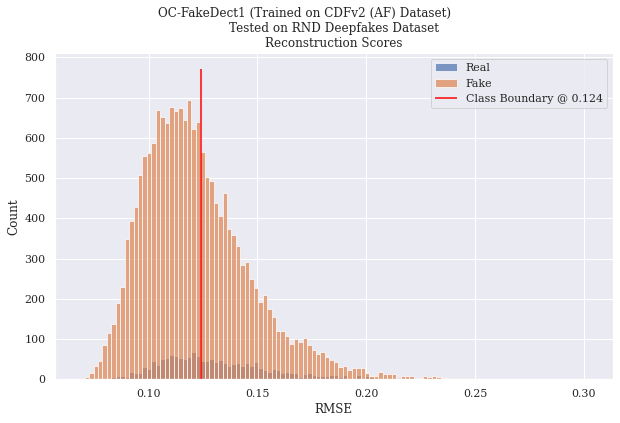

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


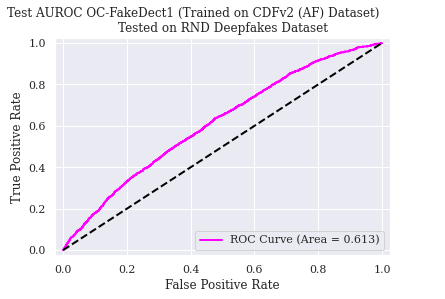

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on AVG Face2Face Dataset                
Running Average Evaluation'
OC-FakeDect1_AVG
Face2Face_avg
../../_DATASETS/FF/Face2Face_avg
OC-FakeDect1_AVG_raeonF2Favg




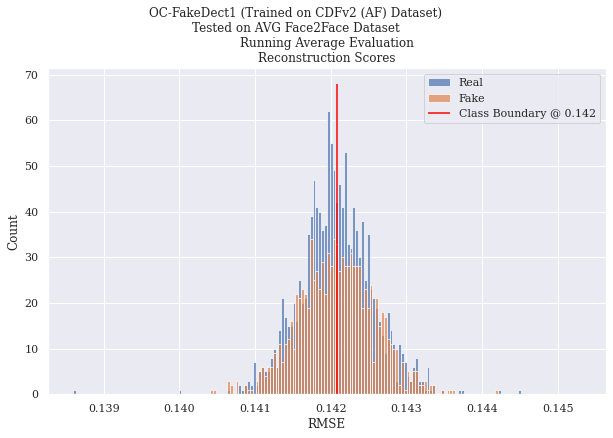

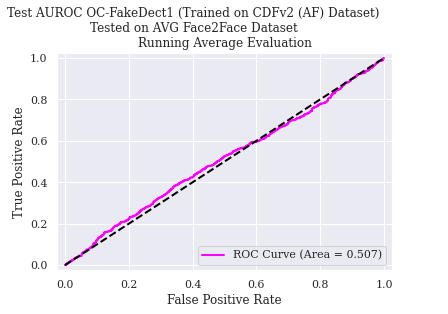

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on AVG Face2Face Dataset'
OC-FakeDect1_AVG
Face2Face_avg
../../_DATASETS/FF/Face2Face_avg
OC-FakeDect1_AVG_F2Favg




100%|██████████| 18038/18038 [01:01<00:00, 293.06it/s]


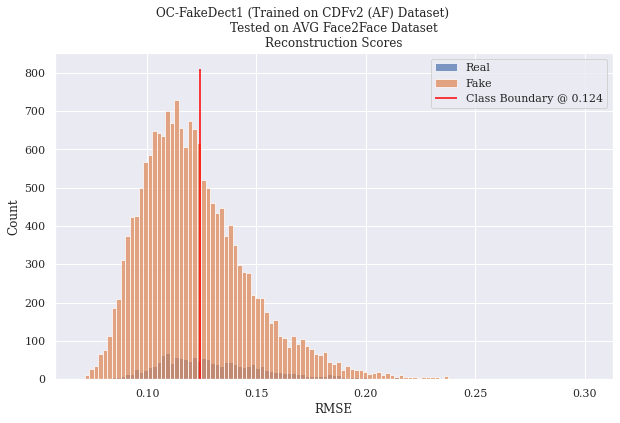

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


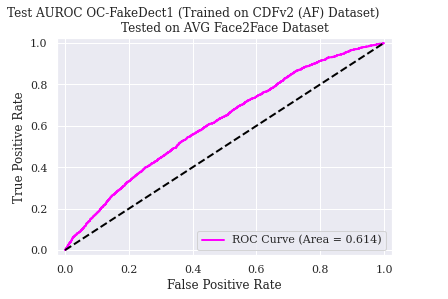

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on RND Face2Face Dataset                
Running Average Evaluation'
OC-FakeDect1_AVG
Face2Face_rnd
../../_DATASETS/FF/Face2Face_rnd
OC-FakeDect1_AVG_raeonF2Frnd




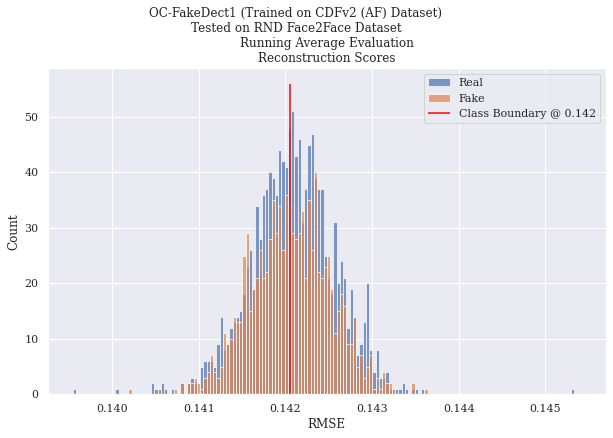

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


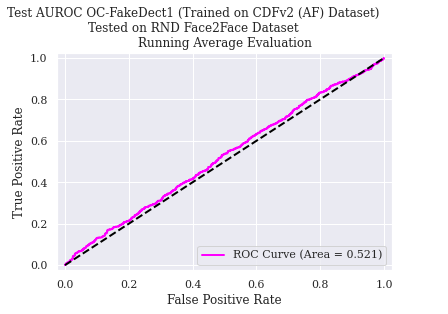

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on RND Face2Face Dataset'
OC-FakeDect1_AVG
Face2Face_rnd
../../_DATASETS/FF/Face2Face_rnd
OC-FakeDect1_AVG_F2Frnd




100%|██████████| 18038/18038 [01:01<00:00, 292.54it/s]


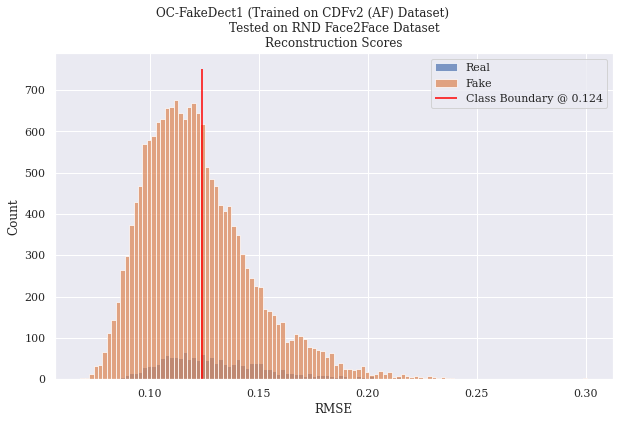

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


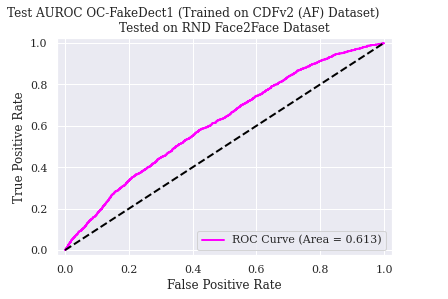

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on AVG FaceShifter Dataset                
Running Average Evaluation'
OC-FakeDect1_AVG
FaceShifter_avg
../../_DATASETS/FF/FaceShifter_avg
OC-FakeDect1_AVG_raeonFSHFTavg




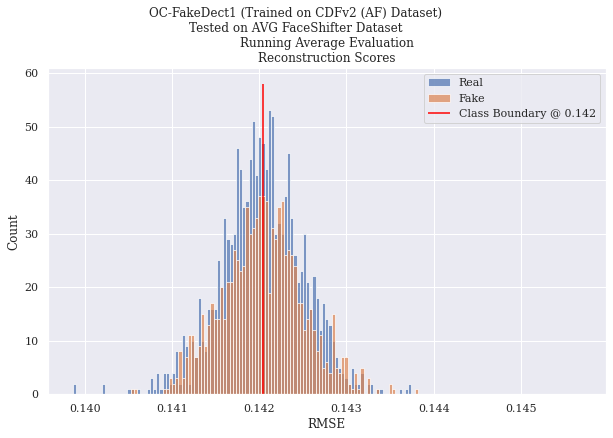

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


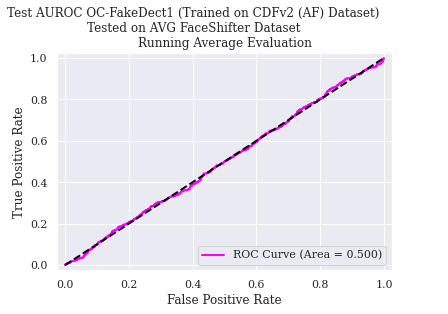

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on AVG FaceShifter Dataset'
OC-FakeDect1_AVG
FaceShifter_avg
../../_DATASETS/FF/FaceShifter_avg
OC-FakeDect1_AVG_FSHFTavg




100%|██████████| 18038/18038 [01:01<00:00, 291.92it/s]


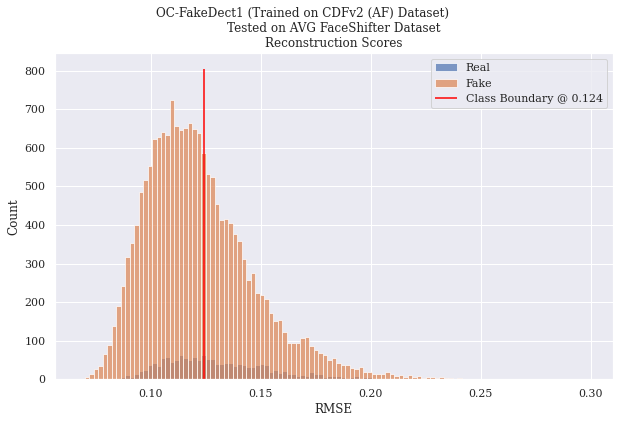

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


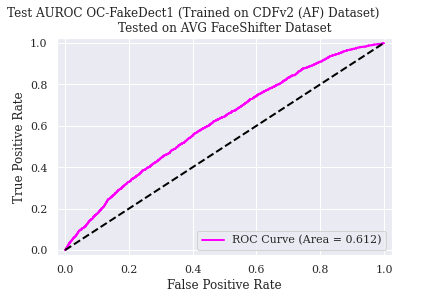

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on RND FaceShifter Dataset                
Running Average Evaluation'
OC-FakeDect1_AVG
FaceShifter_rnd
../../_DATASETS/FF/FaceShifter_rnd
OC-FakeDect1_AVG_raeonFSHFTrnd




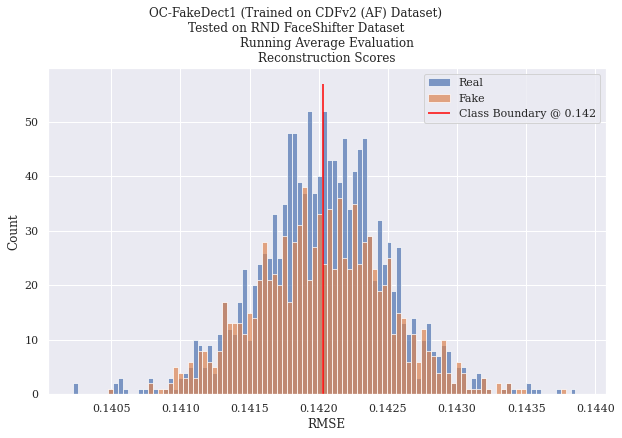

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


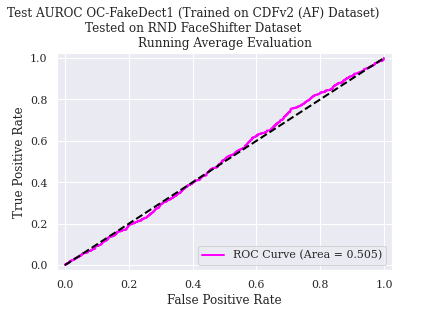

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on RND FaceShifter Dataset'
OC-FakeDect1_AVG
FaceShifter_rnd
../../_DATASETS/FF/FaceShifter_rnd
OC-FakeDect1_AVG_FSHFTrnd




100%|██████████| 18038/18038 [01:01<00:00, 291.58it/s]


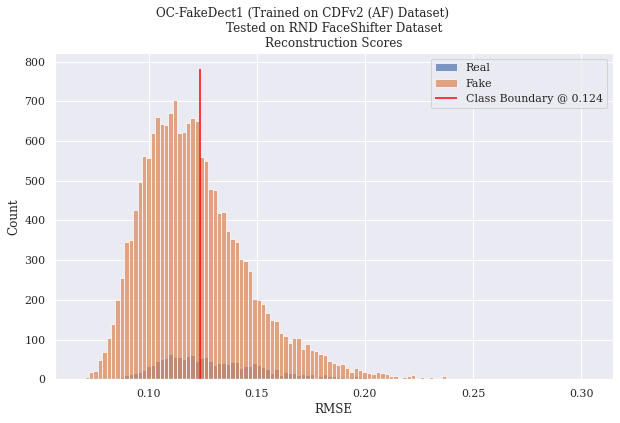

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


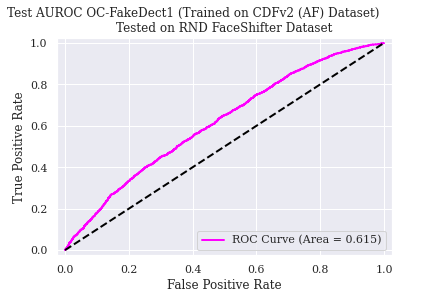

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on AVG FaceSwap Dataset                
Running Average Evaluation'
OC-FakeDect1_AVG
FaceSwap_avg
../../_DATASETS/FF/FaceSwap_avg
OC-FakeDect1_AVG_raeonFSavg




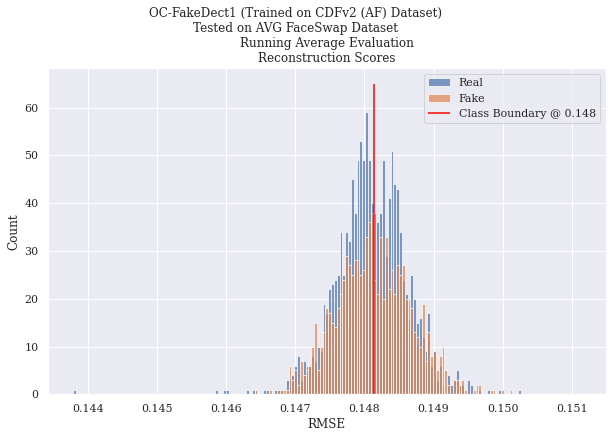

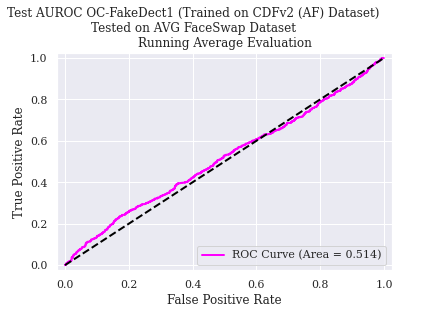

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on AVG FaceSwap Dataset'
OC-FakeDect1_AVG
FaceSwap_avg
../../_DATASETS/FF/FaceSwap_avg
OC-FakeDect1_AVG_FSavg




100%|██████████| 18038/18038 [01:08<00:00, 263.84it/s]


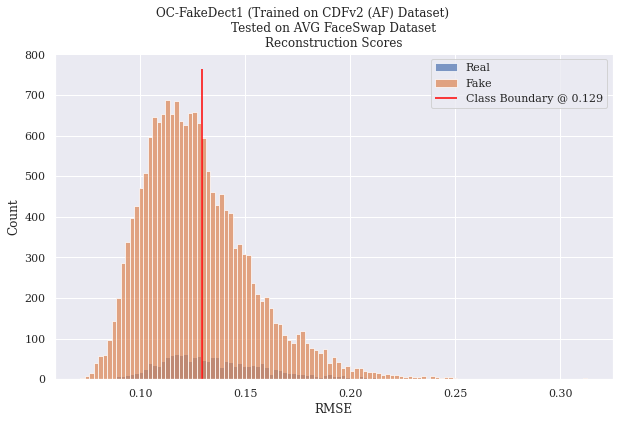

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


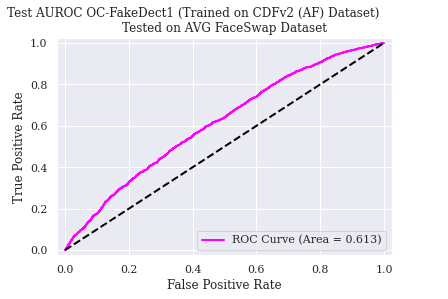

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on RND FaceSwap Dataset                
Running Average Evaluation'
OC-FakeDect1_AVG
FaceSwap_rnd
../../_DATASETS/FF/FaceSwap_rnd
OC-FakeDect1_AVG_raeonFSrnd




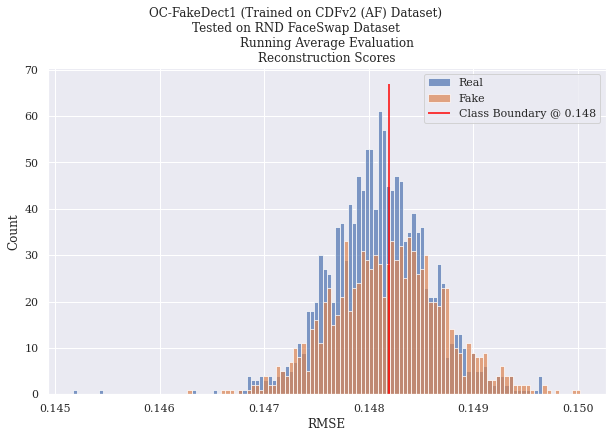

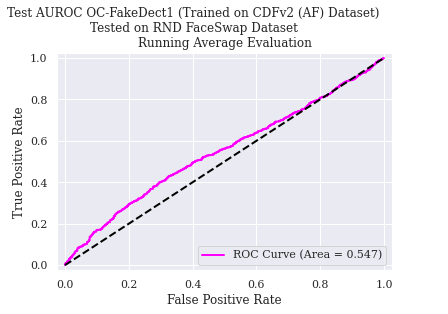

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on RND FaceSwap Dataset'
OC-FakeDect1_AVG
FaceSwap_rnd
../../_DATASETS/FF/FaceSwap_rnd
OC-FakeDect1_AVG_FSrnd




100%|██████████| 18038/18038 [01:01<00:00, 291.29it/s]


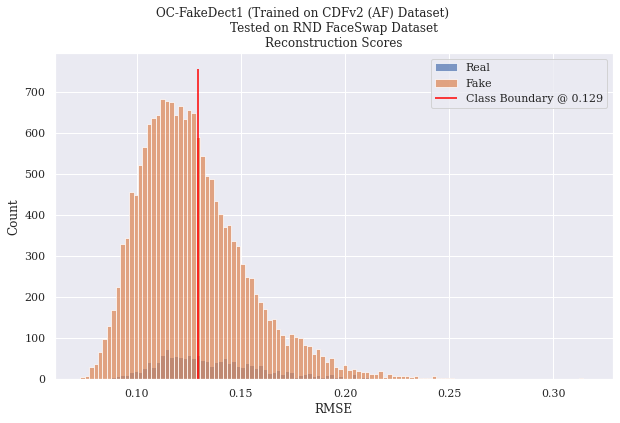

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


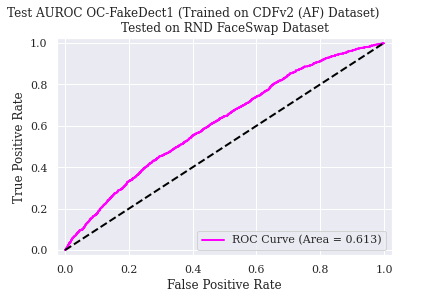

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on AVG NeuralTextures Dataset                
Running Average Evaluation'
OC-FakeDect1_AVG
NeuralTextures_avg
../../_DATASETS/FF/NeuralTextures_avg
OC-FakeDect1_AVG_raeonNTavg




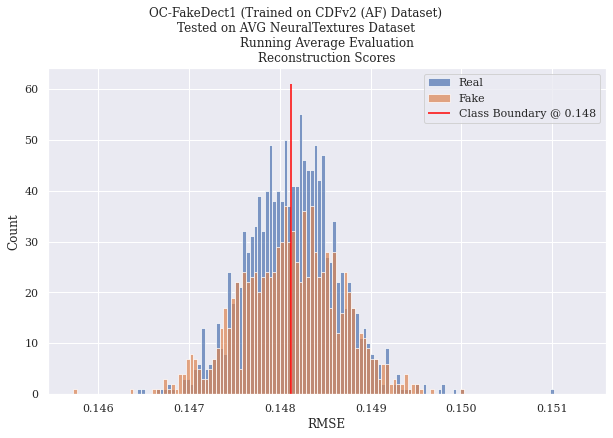

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


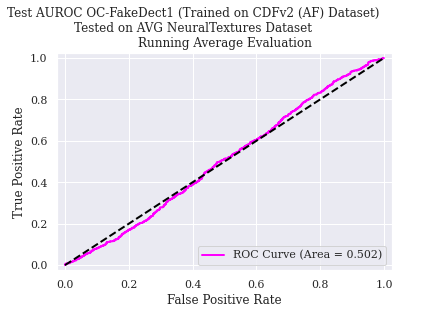

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on AVG NeuralTextures Dataset'
OC-FakeDect1_AVG
NeuralTextures_avg
../../_DATASETS/FF/NeuralTextures_avg
OC-FakeDect1_AVG_NTavg




100%|██████████| 18038/18038 [01:01<00:00, 291.06it/s]


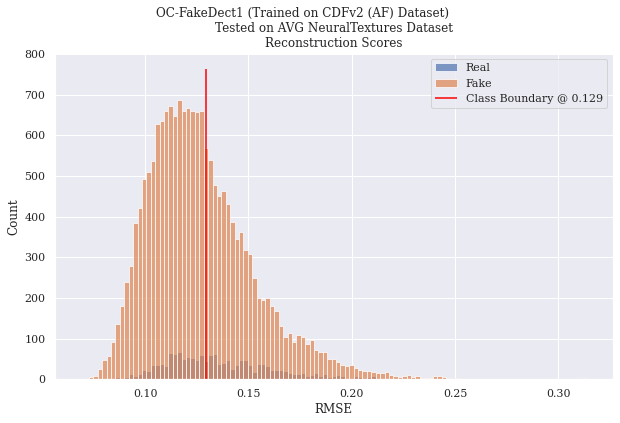

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


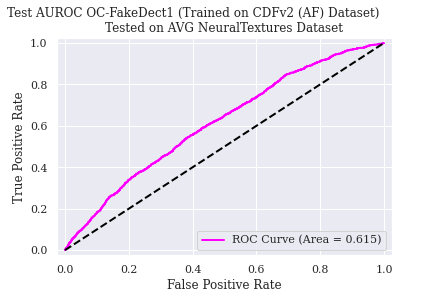

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on RND NeuralTextures Dataset                
Running Average Evaluation'
OC-FakeDect1_AVG
NeuralTextures_rnd
../../_DATASETS/FF/NeuralTextures_rnd
OC-FakeDect1_AVG_raeonNTrnd




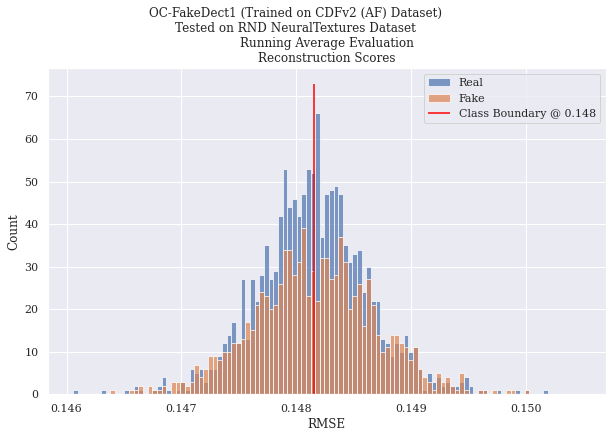

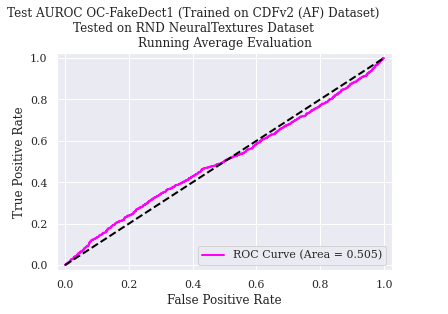

'OC-FakeDect1 (Trained on AVG Dataset)                
Tested on RND NeuralTextures Dataset'
OC-FakeDect1_AVG
NeuralTextures_rnd
../../_DATASETS/FF/NeuralTextures_rnd
OC-FakeDect1_AVG_NTrnd




100%|██████████| 18038/18038 [01:02<00:00, 286.99it/s]


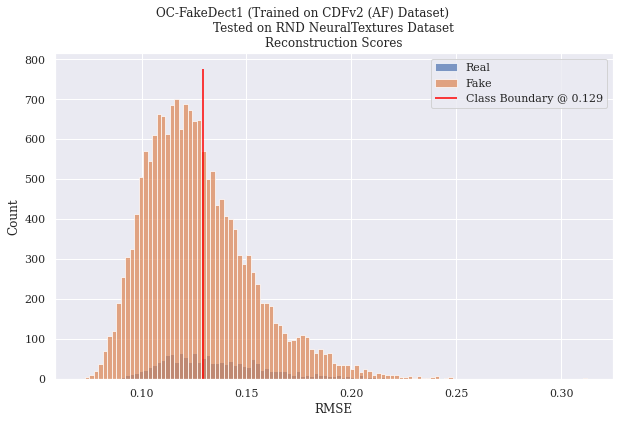

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


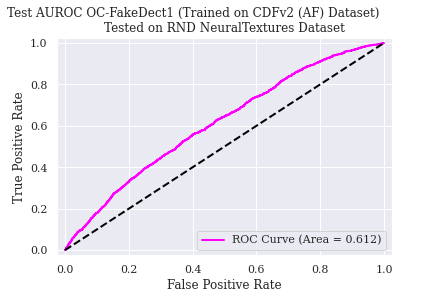

'OC-FakeDect1 (Trained on RND Dataset)               
Tested on DFDB Dataset'
OC-FakeDect1_RND
DariusAf_Deepfake_Database
../../_DATASETS/DariusAf_Deepfake_Database/validation
OC-FakeDect1_RND_onDFDB




100%|██████████| 18038/18038 [01:02<00:00, 290.92it/s]


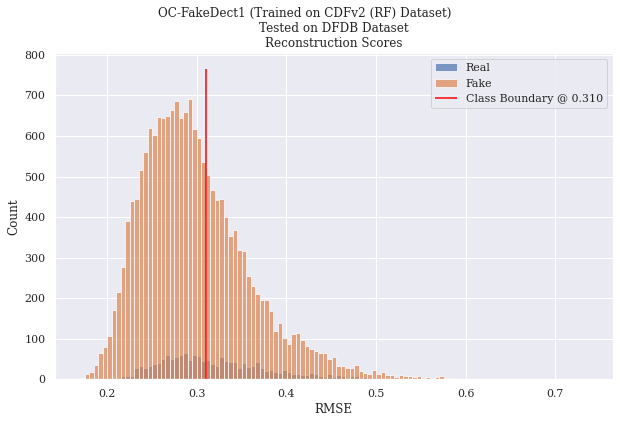

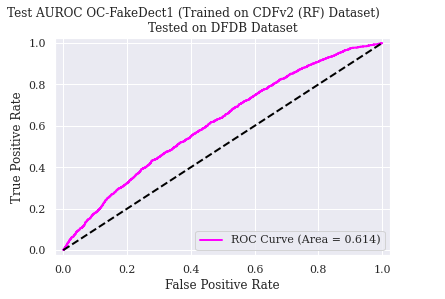

'OC-FakeDect1 (Trained on RND Dataset)               
Tested on AVG CDFv2 Dataset'
OC-FakeDect1_RND
Celeb-avg-30
../../_DATASETS/Celeb-DF-v2/Celeb-avg-30-test
OC-FakeDect1_RND_onAVG




100%|██████████| 18038/18038 [01:02<00:00, 290.59it/s]


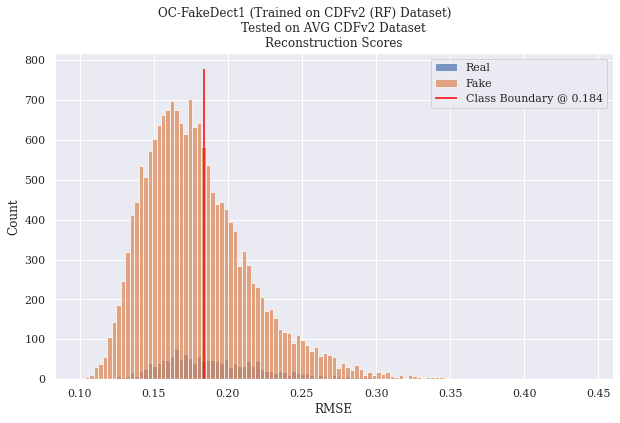

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


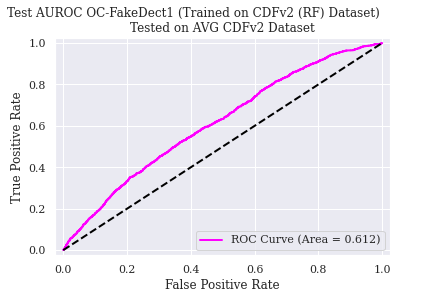

'OC-FakeDect1 (Trained on RND Dataset)               
Tested on RND CDFv2 Dataset'
OC-FakeDect1_RND
Celeb-rnd-30
../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test
OC-FakeDect1_RND_onRND




100%|██████████| 18038/18038 [01:02<00:00, 290.79it/s]


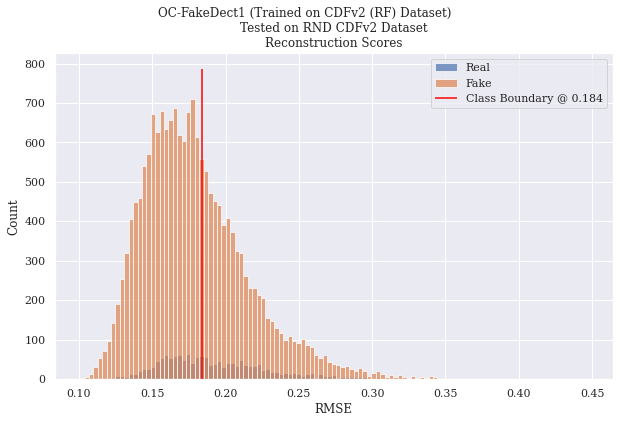

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


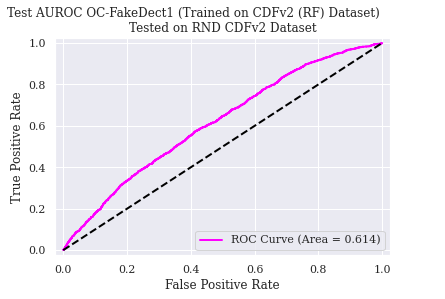

'OC-FakeDect1 (Trained on RND Dataset)               
Tested on AVG CDFv2 Dataset               
Running Average Evaluation'
OC-FakeDect1_RND
Celeb-avg-30
../../_DATASETS/Celeb-DF-v2/Celeb-avg-30-test
OC-FakeDect1_RND_raeonAVG




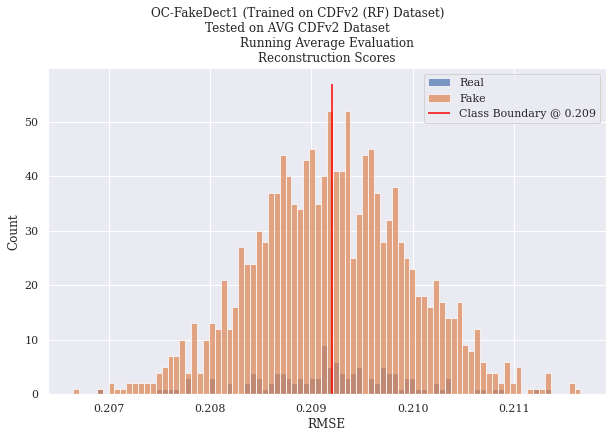

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


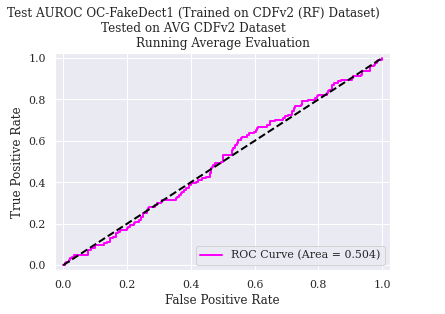

'OC-FakeDect1 (Trained on RND Dataset)               
Tested on RND CDFv2 Dataset               
Running Average Evaluation'
OC-FakeDect1_RND
Celeb-rnd-30
../../_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test
OC-FakeDect1_RND_raeonRND




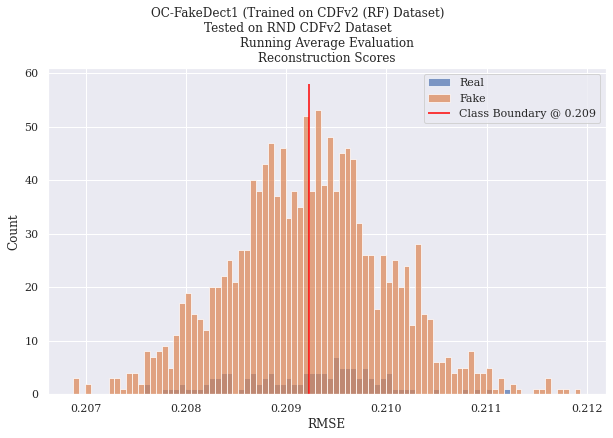

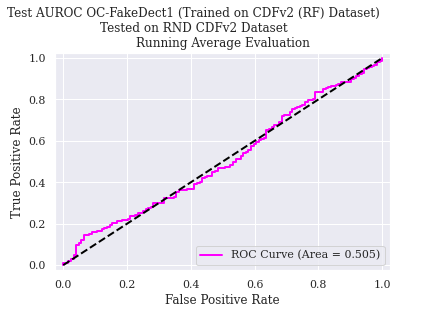

'OC-FakeDect1 (Trained on RND Dataset)               
Tested on AVG Deepfakes Dataset               
Running Average Evaluation'
OC-FakeDect1_RND
Deepfakes_avg
../../_DATASETS/FF/Deepfakes_avg
OC-FakeDect1_RND_raeonDFavg




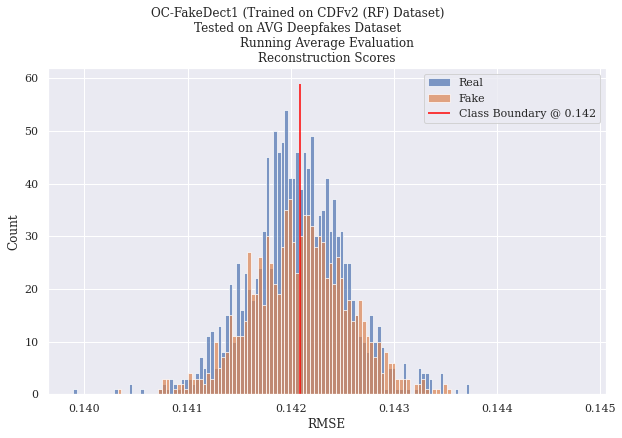

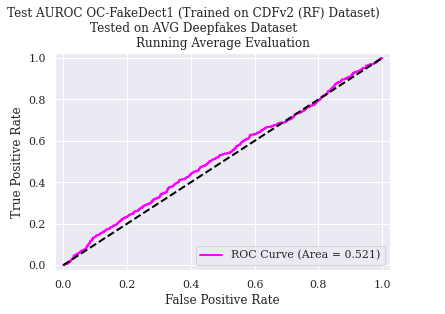

'OC-FakeDect1 (Trained on RND Dataset)               
Tested on AVG Deepfakes Dataset'
OC-FakeDect1_RND
Deepfakes_avg
../../_DATASETS/FF/Deepfakes_avg
OC-FakeDect1_RND_DFavg




100%|██████████| 18038/18038 [01:01<00:00, 291.16it/s]


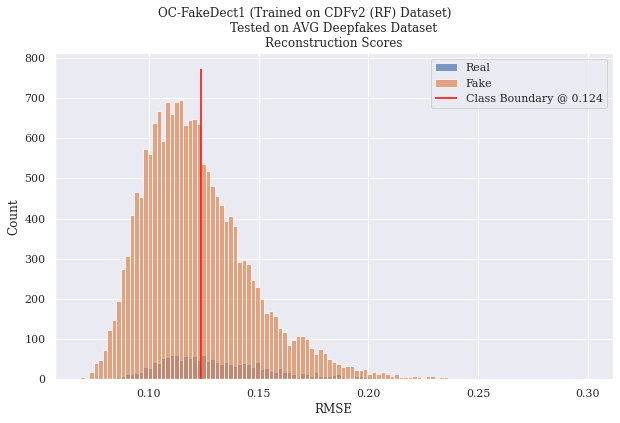

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


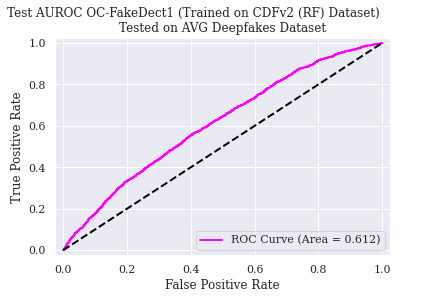

'OC-FakeDect1 (Trained on RND Dataset)               
Tested on RND Deepfakes Dataset               
Running Average Evaluation'
OC-FakeDect1_RND
Deepfakes_rnd
../../_DATASETS/FF/Deepfakes_rnd
OC-FakeDect1_RND_raeonDFrnd




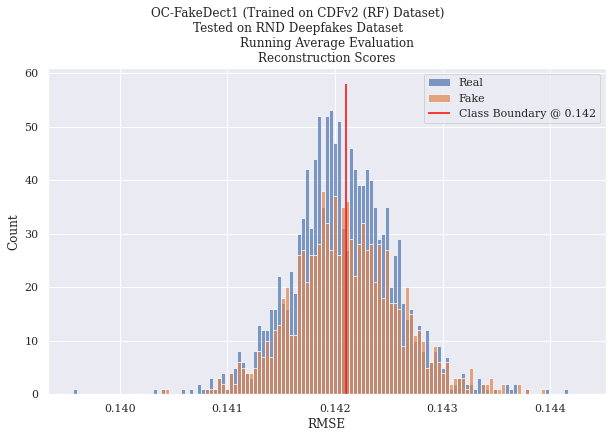

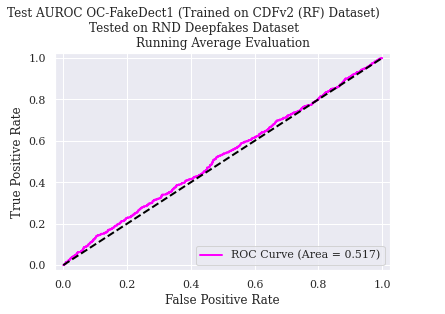

'OC-FakeDect1 (Trained on RND Dataset)               
Tested on RND Deepfakes Dataset'
OC-FakeDect1_RND
Deepfakes_rnd
../../_DATASETS/FF/Deepfakes_rnd
OC-FakeDect1_RND_DFrnd




100%|██████████| 18038/18038 [01:02<00:00, 288.70it/s]


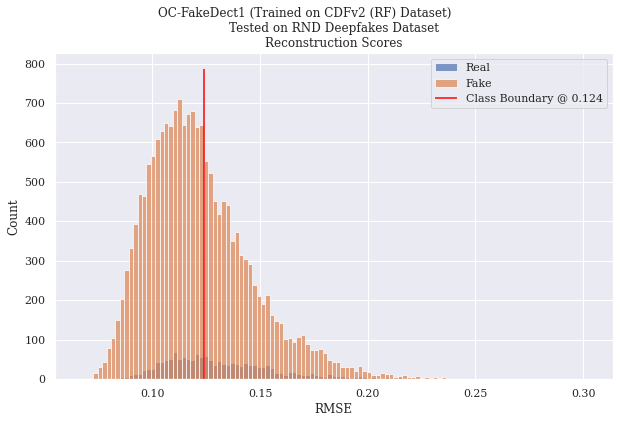

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


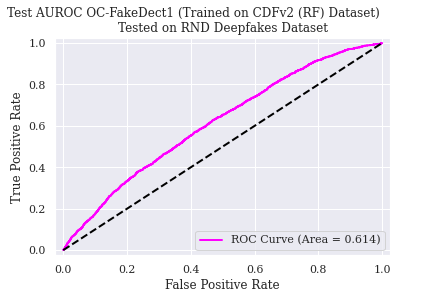

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on AVG Face2Face Dataset                
Running Average Evaluation'
OC-FakeDect1_RND
Face2Face_avg
../../_DATASETS/FF/Face2Face_avg
OC-FakeDect1_RND_raeonF2Favg




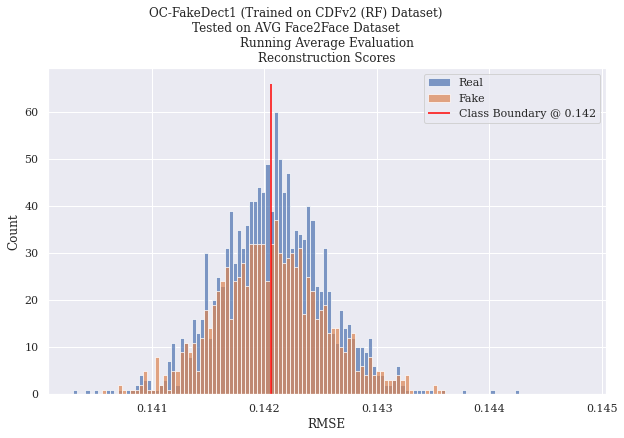

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


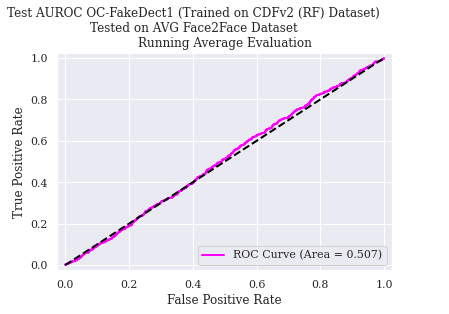

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on AVG Face2Face Dataset'
OC-FakeDect1_RND
Face2Face_avg
../../_DATASETS/FF/Face2Face_avg
OC-FakeDect1_RND_F2Favg




100%|██████████| 18038/18038 [01:02<00:00, 286.63it/s]


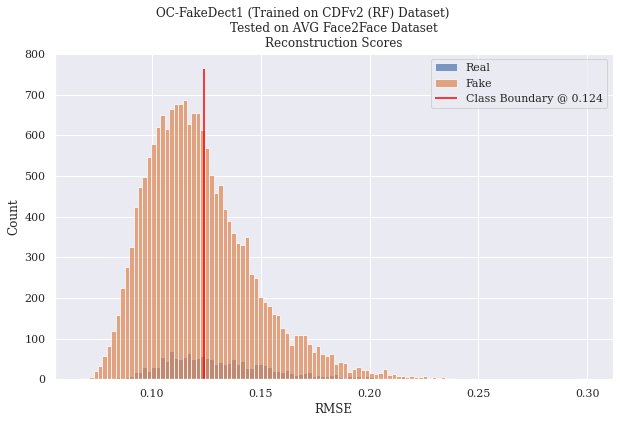

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


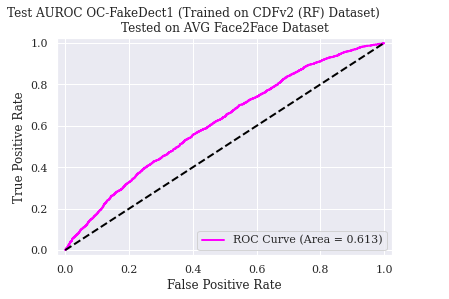

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on RND Face2Face Dataset                
Running Average Evaluation'
OC-FakeDect1_RND
Face2Face_rnd
../../_DATASETS/FF/Face2Face_rnd
OC-FakeDect1_RND_raeonF2Frnd




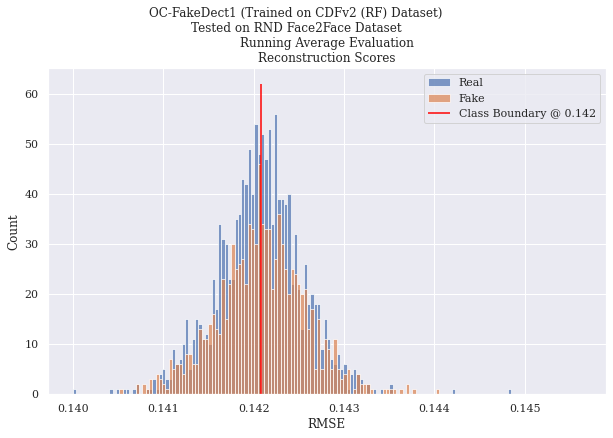

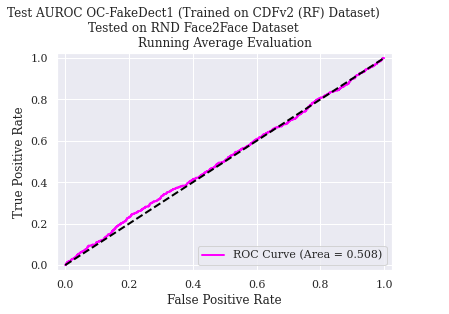

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on RND Face2Face Dataset'
OC-FakeDect1_RND
Face2Face_rnd
../../_DATASETS/FF/Face2Face_rnd
OC-FakeDect1_RND_F2Frnd




100%|██████████| 18038/18038 [01:02<00:00, 288.74it/s]


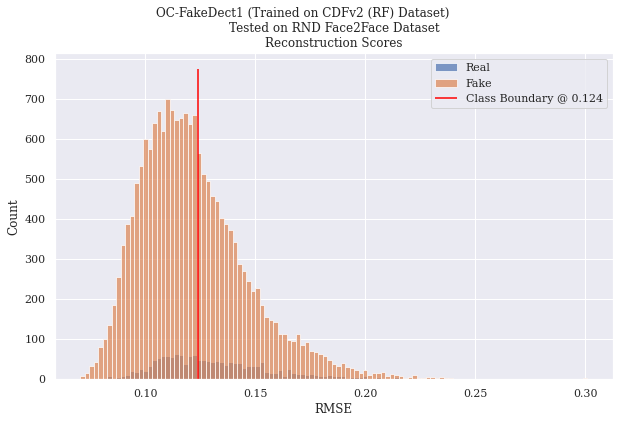

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


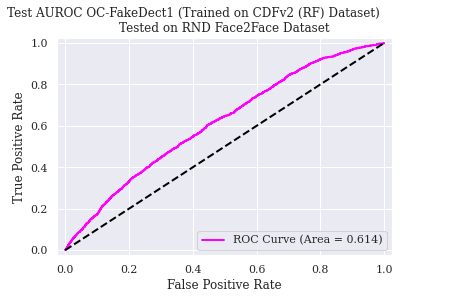

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on AVG FaceShifter Dataset                
Running Average Evaluation'
OC-FakeDect1_RND
FaceShifter_avg
../../_DATASETS/FF/FaceShifter_avg
OC-FakeDect1_RND_raeonFSHFTavg




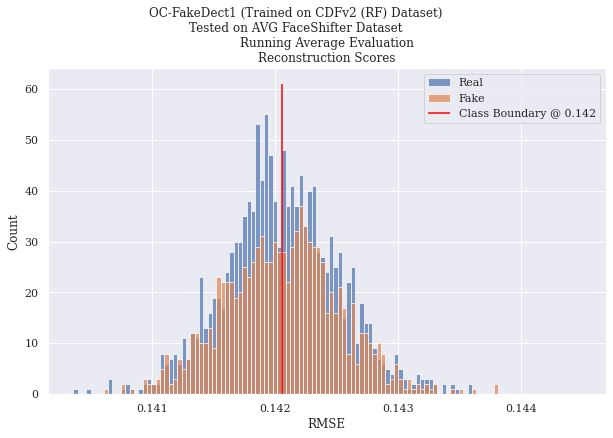

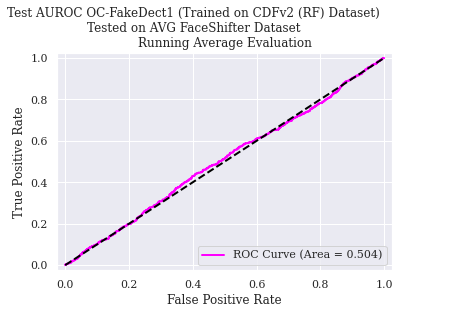

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on AVG FaceShifter Dataset'
OC-FakeDect1_RND
FaceShifter_avg
../../_DATASETS/FF/FaceShifter_avg
OC-FakeDect1_RND_FSHFTavg




100%|██████████| 18038/18038 [01:02<00:00, 286.86it/s]


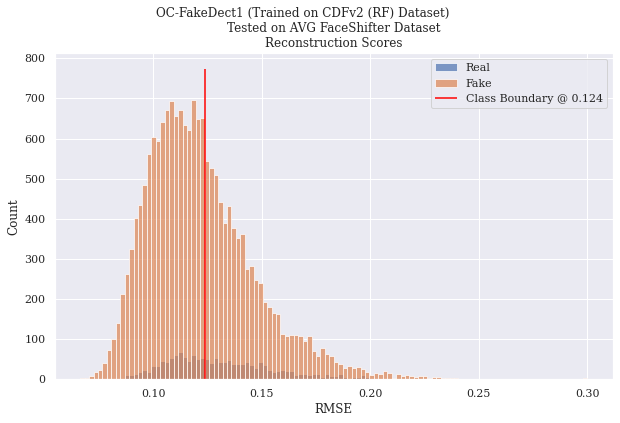

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


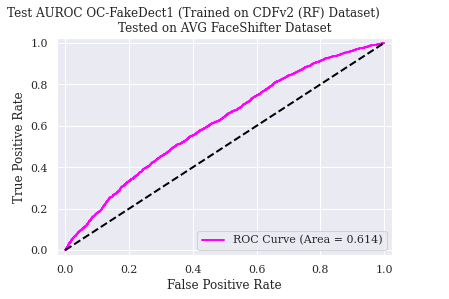

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on RND FaceShifter Dataset                
Running Average Evaluation'
OC-FakeDect1_RND
FaceShifter_rnd
../../_DATASETS/FF/FaceShifter_rnd
OC-FakeDect1_RND_raeonFSHFTrnd




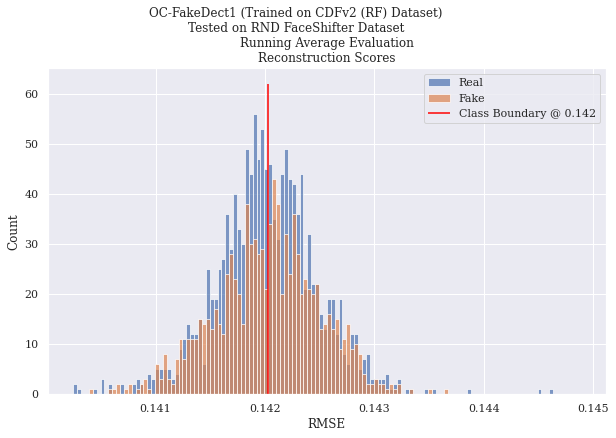

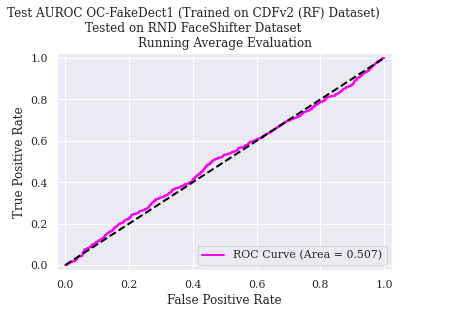

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on RND FaceShifter Dataset'
OC-FakeDect1_RND
FaceShifter_rnd
../../_DATASETS/FF/FaceShifter_rnd
OC-FakeDect1_RND_FSHFTrnd




100%|██████████| 18038/18038 [01:02<00:00, 288.36it/s]


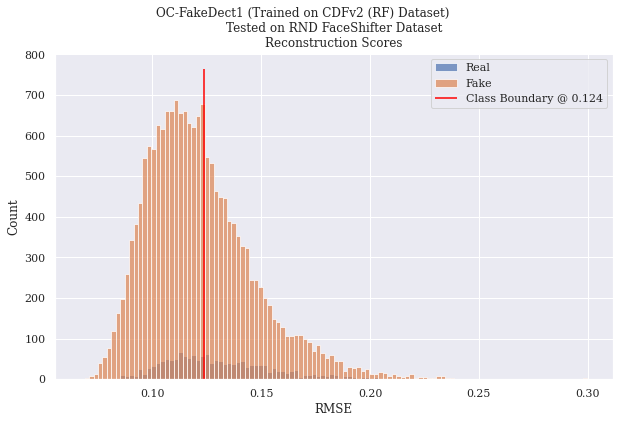

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


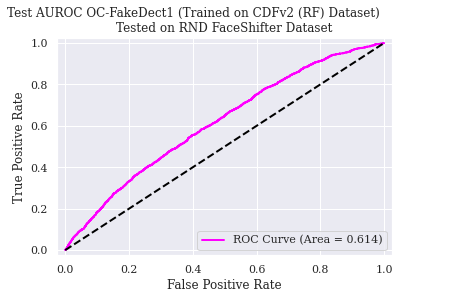

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on AVG FaceSwap Dataset                
Running Average Evaluation'
OC-FakeDect1_RND
FaceSwap_avg
../../_DATASETS/FF/FaceSwap_avg
OC-FakeDect1_RND_raeonFSavg




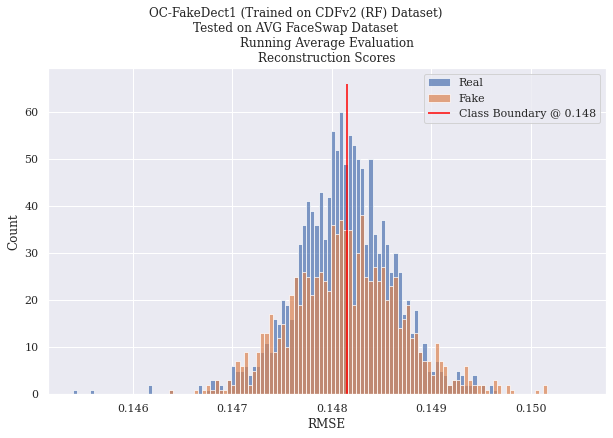

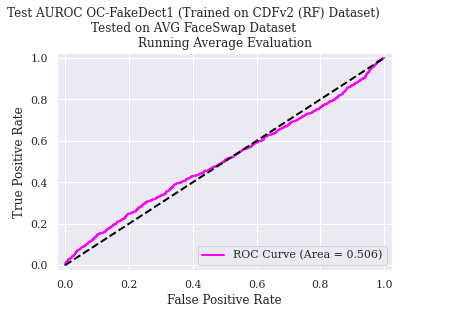

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on AVG FaceSwap Dataset'
OC-FakeDect1_RND
FaceSwap_avg
../../_DATASETS/FF/FaceSwap_avg
OC-FakeDect1_RND_FSavg




100%|██████████| 18038/18038 [01:02<00:00, 287.25it/s]


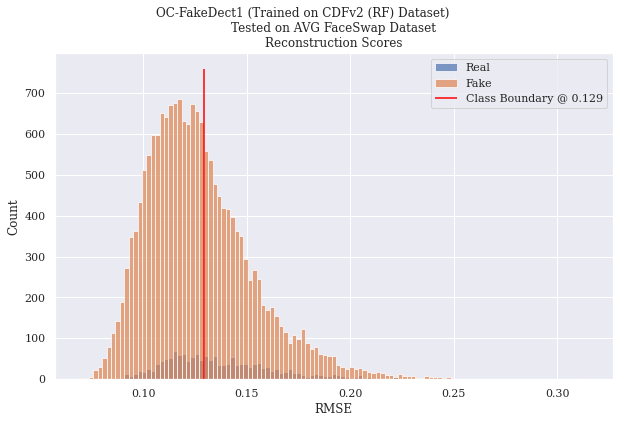

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


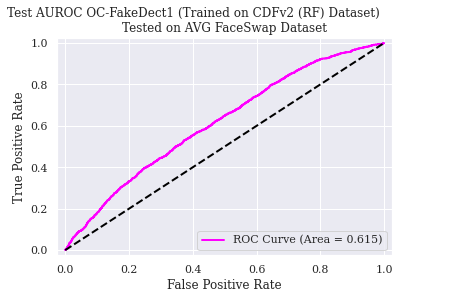

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on RND FaceSwap Dataset                
Running Average Evaluation'
OC-FakeDect1_RND
FaceSwap_rnd
../../_DATASETS/FF/FaceSwap_rnd
OC-FakeDect1_RND_raeonFSrnd




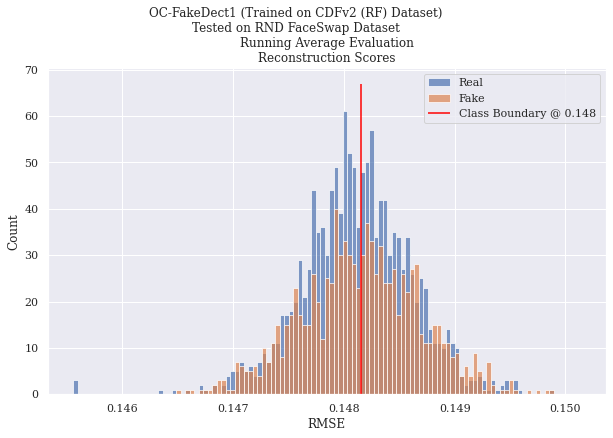

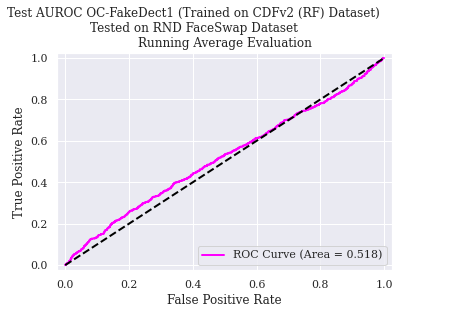

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on RND FaceSwap Dataset'
OC-FakeDect1_RND
FaceSwap_rnd
../../_DATASETS/FF/FaceSwap_rnd
OC-FakeDect1_RND_FSrnd




100%|██████████| 18038/18038 [01:02<00:00, 287.14it/s]


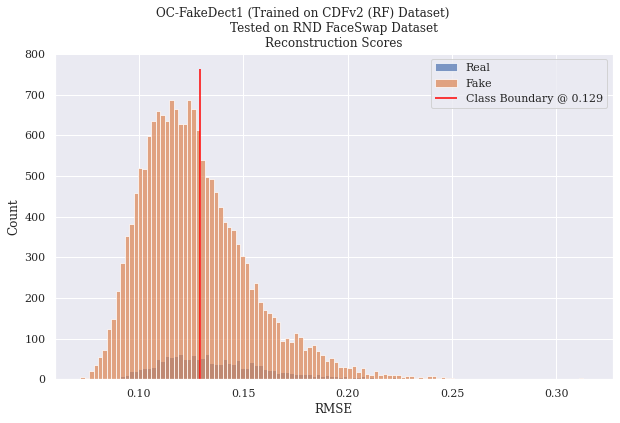

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


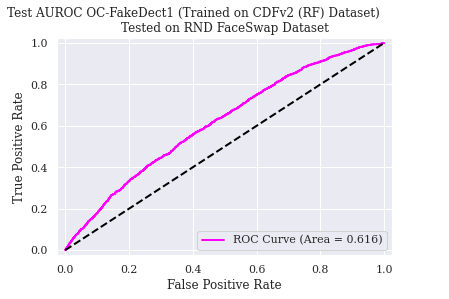

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on AVG NeuralTextures Dataset                
Running Average Evaluation'
OC-FakeDect1_RND
NeuralTextures_avg
../../_DATASETS/FF/NeuralTextures_avg
OC-FakeDect1_RND_raeonNTavg




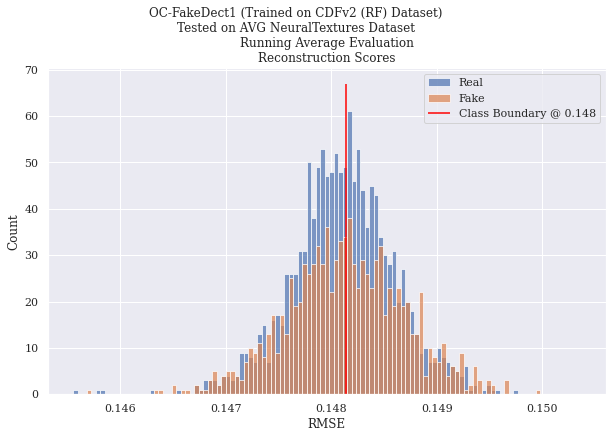

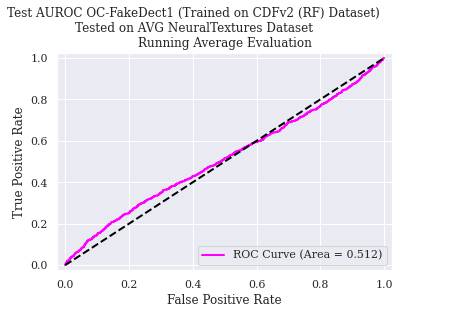

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on AVG NeuralTextures Dataset'
OC-FakeDect1_RND
NeuralTextures_avg
../../_DATASETS/FF/NeuralTextures_avg
OC-FakeDect1_RND_NTavg




100%|██████████| 18038/18038 [01:02<00:00, 288.34it/s]


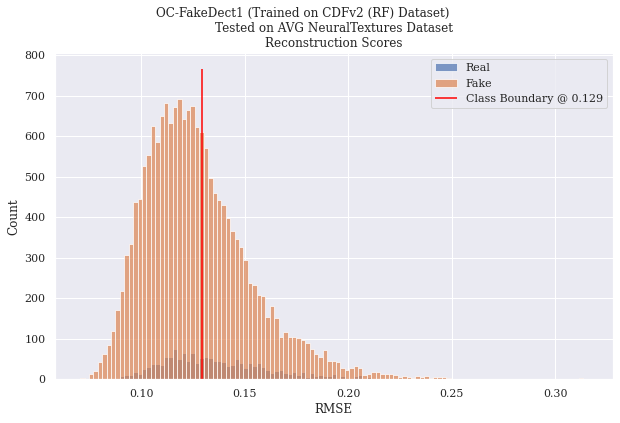

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


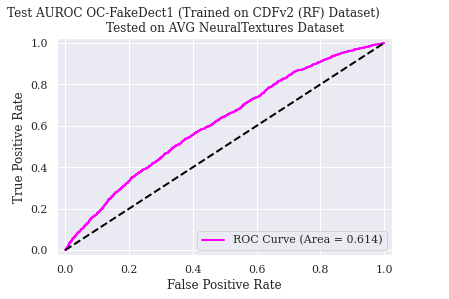

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on RND NeuralTextures Dataset                
Running Average Evaluation'
OC-FakeDect1_RND
NeuralTextures_rnd
../../_DATASETS/FF/NeuralTextures_rnd
OC-FakeDect1_RND_raeonNTrnd




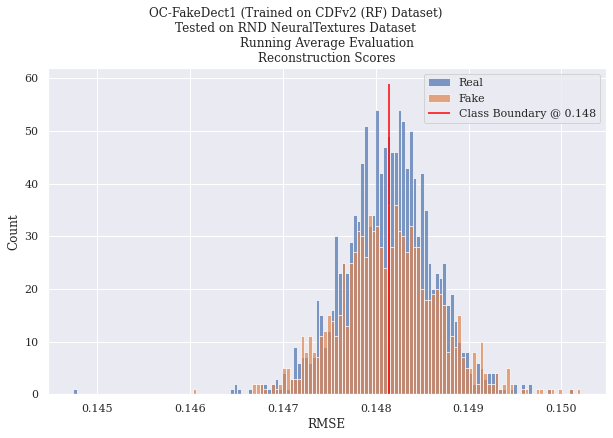

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


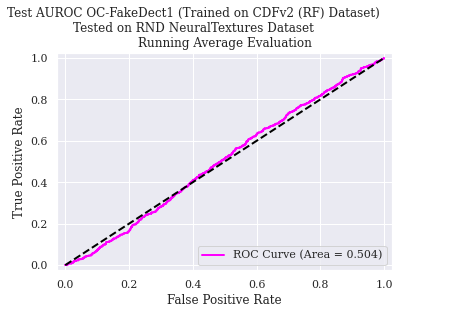

'OC-FakeDect1 (Trained on RND Dataset)                
Tested on RND NeuralTextures Dataset'
OC-FakeDect1_RND
NeuralTextures_rnd
../../_DATASETS/FF/NeuralTextures_rnd
OC-FakeDect1_RND_NTrnd




100%|██████████| 18038/18038 [01:02<00:00, 286.58it/s]


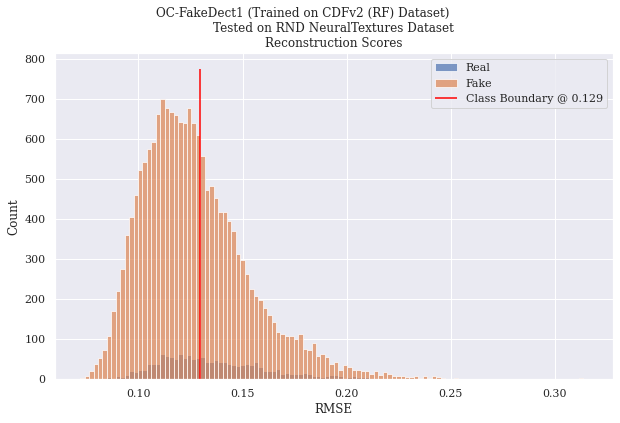

C:\Users\rapto\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


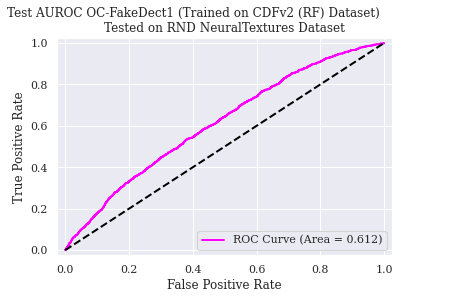

In [66]:
for dataset_name, weights_path in zip(["DFDB", "AVG", "RND"], ["OC_FD_e204_l1429_DFDB.pkl", "OC_FD_e29_l500_AVG.pkl", "OC_FD_e2_l532_RND.pkl"]):
    torch.load("../../_WEIGHTS/oc_fakedect/"+weights_path)
                  # experiment_name,                                       model_name,          testset_name,                 fname
    EXPERIMENTS = [

                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on DFDB Dataset",  f"OC-FakeDect1_{dataset_name}", "DariusAf_Deepfake_Database", f"OC-FakeDect1_{dataset_name}_onDFDB"),

                # OC-FakeDect1 RND on Celebs indep eval
               (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on AVG CDFv2 Dataset",  f"OC-FakeDect1_{dataset_name}", "Celeb-avg-30", f"OC-FakeDect1_{dataset_name}_onAVG"),

               (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on RND CDFv2 Dataset",  f"OC-FakeDect1_{dataset_name}", "Celeb-rnd-30", f"OC-FakeDect1_{dataset_name}_onRND"),

                # OC-FakeDect1 RND on Celebs rae
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on AVG CDFv2 Dataset\
               \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Celeb-avg-30", f"OC-FakeDect1_{dataset_name}_raeonAVG"),

               (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on RND CDFv2 Dataset\
               \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Celeb-rnd-30", f"OC-FakeDect1_{dataset_name}_raeonRND"),

                # OC-FakeDect1 RND on FF indep eval
                # DF
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on AVG Deepfakes Dataset\
               \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_avg", f"OC-FakeDect1_{dataset_name}_raeonDFavg"),
             
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on AVG Deepfakes Dataset",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_avg", f"OC-FakeDect1_{dataset_name}_DFavg"),
             
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on RND Deepfakes Dataset\
               \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_rnd", f"OC-FakeDect1_{dataset_name}_raeonDFrnd"),
             
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
               \nTested on RND Deepfakes Dataset",  f"OC-FakeDect1_{dataset_name}", "Deepfakes_rnd", f"OC-FakeDect1_{dataset_name}_DFrnd"),

                # F2F
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG Face2Face Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Face2Face_avg", f"OC-FakeDect1_{dataset_name}_raeonF2Favg"),
             
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG Face2Face Dataset",  f"OC-FakeDect1_{dataset_name}", "Face2Face_avg", f"OC-FakeDect1_{dataset_name}_F2Favg"),
              
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND Face2Face Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "Face2Face_rnd", f"OC-FakeDect1_{dataset_name}_raeonF2Frnd"),
               
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND Face2Face Dataset",  f"OC-FakeDect1_{dataset_name}", "Face2Face_rnd", f"OC-FakeDect1_{dataset_name}_F2Frnd"),

                # FaceShifter
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG FaceShifter Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_avg", f"OC-FakeDect1_{dataset_name}_raeonFSHFTavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG FaceShifter Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_avg", f"OC-FakeDect1_{dataset_name}_FSHFTavg"),
               
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND FaceShifter Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_rnd", f"OC-FakeDect1_{dataset_name}_raeonFSHFTrnd"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND FaceShifter Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceShifter_rnd", f"OC-FakeDect1_{dataset_name}_FSHFTrnd"),

                # FaceSwap
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG FaceSwap Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_avg", f"OC-FakeDect1_{dataset_name}_raeonFSavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG FaceSwap Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_avg", f"OC-FakeDect1_{dataset_name}_FSavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND FaceSwap Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_rnd", f"OC-FakeDect1_{dataset_name}_raeonFSrnd"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND FaceSwap Dataset",  f"OC-FakeDect1_{dataset_name}", "FaceSwap_rnd", f"OC-FakeDect1_{dataset_name}_FSrnd"),

                # NeuralTextures
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG NeuralTextures Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_avg", f"OC-FakeDect1_{dataset_name}_raeonNTavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on AVG NeuralTextures Dataset",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_avg", f"OC-FakeDect1_{dataset_name}_NTavg"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND NeuralTextures Dataset\
                \nRunning Average Evaluation",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_rnd", f"OC-FakeDect1_{dataset_name}_raeonNTrnd"),
                
                (f"OC-FakeDect1 (Trained on {dataset_name} Dataset)\
                \nTested on RND NeuralTextures Dataset",  f"OC-FakeDect1_{dataset_name}", "NeuralTextures_rnd", f"OC-FakeDect1_{dataset_name}_NTrnd"),
               ]
    for experiment_name, model_name, testset_name, fname in EXPERIMENTS:
        _, _, trainset = get_binary_testset(testset_name)
        print(f"'{experiment_name}'", model_name, testset_name, trainset, fname, "\n", sep="\n")

        # recon scores
        test_n = sum([len(files) for _, _, files in os.walk(trainset)])  # // batch_size
        score = {0: [], 1: []}
        avg_eval = "running" in experiment_name.lower()
        if avg_eval:
            # running average eval, set of images from each video is single data point (not indep.)
            path_to_testset_real_class = f"{trainset}/{[d for d in os.listdir(trainset) if 'real' in d][0]}"
            path_to_testset_fake_class = f"{trainset}/{[d for d in os.listdir(trainset) if 'real' not in d][0]}"

            for y_dir_pth, y_label in [(path_to_testset_fake_class, 1), (path_to_testset_real_class, 0)]:
                img_dir_list = os.listdir(y_dir_pth)
                Vpths = []
                # loop over all single videos
                for og_fname in set([re.split("_\d+.png", img_name)[0] for img_name in img_dir_list]):

                    all_imgs_for_vid = [i for i in img_dir_list if og_fname in i]
                    path_all_imgs_for_vid = [f"{y_dir_pth}/{i}" for i in all_imgs_for_vid]
                    rsmeS = []

                    # loop over all frames from single video
                    for path_to_test_img in path_all_imgs_for_vid:
                        image = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
                        image = transform_test(image)
                        image = image.float().to(device)

                        fakedect.eval()  # test mode
                        with torch.no_grad():
                            x = image.view(-1, 3, 100, 100)
                            x_prime, _, _ = fakedect(x)
                            xi = x.flatten()
                            xo = x_prime.flatten()
                        rsmeS += [((((xi.cpu() - xo.cpu()) ** 2).sum() / test_n) ** 0.5).item()]
                    score[y_label] += [np.average(rsmeS)]
        else:
            for class_dir in os.listdir(f"{testset}/"):
                y = 0 if "real" in class_dir else 1
                for test_img in tqdm(os.listdir(f"{testset}/{class_dir}")):
                    test_img_path = f"{testset}/{class_dir}/{test_img}"
                    if (
                        ".png" in test_img_path
                        or ".jpg" in test_img_path
                        or ".jpeg" in test_img_path
                    ):
                        image = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
                        image = transform_test(image)
                        image = image.float().to(device)

                        fakedect.eval()  # test mode
                        with torch.no_grad():
                            x = image.view(-1, 3, 100, 100)
                            x_prime, _, _ = fakedect(x)
                            xi = x.flatten()
                            xo = x_prime.flatten()
                        rsme = ((((xi.cpu() - xo.cpu()) ** 2).sum() / test_n) ** 0.5).item()
                        score[y] += [rsme]

        y_true = np.array([0] * len(score[0]) + [1] * len(score[1]))
        y_pred = np.array(score[0] + score[1])

        k = max(np.array(score[0]).std() * 0.075, np.array(score[1]).std() * 0.075)
        min_r, max_r = min(min(score[0]), min(score[1])), max(max(score[0]), max(score[1]))
        bins = [x for x in np.arange(min_r, max_r, k)]

        figure(figsize=(10, 6))  # , dpi = 80)
        c0, _, p = plt.hist(score[0], bins, alpha=0.7, label="Real")
        c1, _, p = plt.hist(score[1], bins, alpha=0.7, label="Fake")
    
        mode_0s = bins[np.where(c0 == c0.max())[0][0]] #np.array(score[0]).mean()
        mode_1s = bins[np.where(c1 == c1.max())[0][0]] #np.array(score[1]).mean()

        # determine best threshold (highest f1)
        threshold_canditates = []
        for t in bins:
            y_pred_rint = (y_pred <= t).astype(float)
            threshold_canditates += [(f1_score(y_true, y_pred_rint), t)]
        threshold = max(threshold_canditates, key=lambda t: t[0])[1]

        # if threshold is not in between means, this is messed up and we need to try and new strat
        if not (min(mode_0s, mode_1s) <= threshold <= max(mode_0s, mode_1s)):
            try:
                threshold = solve(np.mean(score[1]), np.mean(score[0]), np.var(score[1]), np.mean(score[0]))[0]
            except LinAlgError:
                threshold = (mode_0s + mode_1s)/2 # mid point between modes

        plt.vlines(
            threshold,
            0,
            int(max(max(c0), max(c1)) // 0.9),
            colors="red",
            label=f"Class Boundary @ {threshold:.3f}",
        )
        plt.legend()
        plt.xlabel("RMSE")
        plt.ylabel("Count")
        plt.title(f"{experiment_name.replace('Trained on RND', 'Trained on CDFv2 (RF)').replace('Trained on AVG', 'Trained on CDFv2 (AF)')}\nReconstruction Scores")
        plt.savefig(f"Results/thrsh_{fname}.pdf", bbox_inches="tight")
        plt.show()

        auroc = roc_auc_score(y_true, y_pred)
        fpr, tpr, _ = roc_curve(y_true, y_pred)

        # If model is worse than random but so much worse that, it's predicting the opposite way
        if auroc < 0.5:
            auroc = 1 - auroc
            fpr, tpr = tpr, fpr
            y_pred = np.ones(y_pred.shape) - y_pred
        # Get F1, Precision and Recall (WITH BEST THRESHOLD)
        y_pred_rint = (y_pred <= threshold).astype(float)
        f1 = f1_score(y_true, y_pred_rint)
        prec = precision_score(y_true, y_pred_rint)
        recall = recall_score(y_true, y_pred_rint)

        # Plot AUC
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color="magenta", lw=lw, label="ROC Curve (Area = %0.3f)" % auroc)
        plt.plot([0, 1], [0, 1], color="black", lw=lw, linestyle="--")
        extra_xylim = 0.025
        plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
        plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Test AUROC {experiment_name.replace('Trained on RND', 'Trained on CDFv2 (RF)').replace('Trained on AVG', 'Trained on CDFv2 (AF)')}")
        plt.legend(loc="lower right")
        plt.savefig(f"./Results/{fname}_AUC.pdf", bbox_inches="tight")
        plt.show()

        with open(f"./Results/{fname}.txt", "w") as f:
            f.write(f"{experiment_name, model_name, dataset_name, fname}\n")
            f.write(f"auroc={auroc}\n")
            f.write(f"f1={f1}\n")
            f.write(f"prec={prec}\n")
            f.write(f"recall={recall}\n")
            f.write(f"\nfpr={[f for f in fpr]}\n")
            f.write(f"\ntpr={[t for t in tpr]}\n")
            f.write(f"\ny_true={[t for t in y_true]}\n")
            f.write(f"\ny_pred={[p[0] if 'arr' in str(type(p)) and len(p) else p for p in y_pred]}\n")
            f.write(f"\score={score}")
    # break


In [ ]:

# for dataset_name in ("DFDB", "CDFv2 (AF)", "CDFv2 (DF)")
#     for experiment_name, model_name, testset_name, fname in EXPERIMENTS[:1]:
#         print(experiment_name, model_name, testset_name, fname, "\n", sep="\n")
#         _, _, trainset = get_binary_testset(testset_name)

#         # recon scores
#         test_n = sum([len(files) for _, _, files in os.walk(trainset)]) #// batch_size
#         score = {0:[],1:[]}
#         avg_eval = "running" in experiment_name.lower()
#         if avg_eval:
#             # running average eval, set of images from each video is single data point (not indep.)
#             path_to_testset_real_class = f"{trainset}/{[d for d in os.listdir(trainset) if 'real' in d][0]}"
#             path_to_testset_fake_class = f"{trainset}/{[d for d in os.listdir(trainset) if 'real' not in d][0]}"

#             for y_dir_pth, y_label in [(path_to_testset_fake_class, 1), (path_to_testset_real_class, 0)]:
#                 img_dir_list = os.listdir(y_dir_pth)
#                 Vpths = []
#                 # loop over all single videos
#                 for og_fname in set([re.split('_\d+.png', img_name)[0] for img_name in img_dir_list]):

#                     all_imgs_for_vid = [i for i in img_dir_list if og_fname in i]
#                     path_all_imgs_for_vid = [f"{y_dir_pth}/{i}" for i in all_imgs_for_vid]
#                     rsmeS = []

#                     # loop over all frames from single video
#                     for path_to_test_img in path_all_imgs_for_vid:
#                         image = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
#                         image = transform_test(image)
#                         image = image.float().to(device)

#                         fakedect.eval() # test mode
#                         with torch.no_grad():
#                             x = image.view(-1,3,100,100)
#                             x_prime, _, _ = fakedect(x)
#                             # z_mean, z_logvar = fakedect.encode(x_prime)
#                             xi = x.flatten()
#                             xo = x_prime.flatten()
#                         rsmeS += [((((xi.cpu() - xo.cpu())**2).sum()/test_n)**0.5).item()]
#                     score[y_label] += [np.average(rsmeS)]

#         else:
#             for class_dir in os.listdir(f"{testset}/"):
#                 y = 0 if "real" in class_dir else 1
#                 for test_img in tqdm(os.listdir(f"{testset}/{class_dir}")):
#                     test_img_path = f"{testset}/{class_dir}/{test_img}"
#                     if ".png" in test_img_path or ".jpg" in test_img_path or ".jpeg" in test_img_path:
#                         image = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
#                         image = transform_test(image)
#                         image = image.float().to(device)

#                         fakedect.eval() # test mode
#                         with torch.no_grad():
#                             x = image.view(-1,3,100,100)
#                             x_prime, _, _ = fakedect(x)
#                             # z_mean, z_logvar = fakedect.encode(x_prime)
#                             xi = x.flatten()
#                             xo = x_prime.flatten()
#                         rsme = ((((xi.cpu() - xo.cpu())**2).sum()/test_n)**0.5).item()
#                         score[y] += [rsme]
        
#         k = max(np.array(score[0]).std() * 0.075, np.array(score[1]).std() * 0.075)
#         min_r, max_r = min(min(score[0]), min(score[1])), max(max(score[0]), max(score[1]))
#         bins = [x for x in np.arange(min_r, max_r, k)]

#         try:
#             threshold = solve(np.mean(score[1]), np.mean(score[0]), np.var(score[1]), np.mean(score[0]))[0]
#         except LinAlgError:
#             threshold = (min_r+max_r)/2

#         figure(figsize = (10, 6))#, dpi = 80)
#         c0,_,p = plt.hist(score[0], bins, alpha=0.7, label="Real")
#         c1,_,p = plt.hist(score[1], bins, alpha=0.7, label="Fake")
#         plt.vlines(threshold, 0, int(max(max(c0),max(c1))//0.9), colors="red", label=f"Class Boundary @ {threshold:.3f}" )
#         plt.legend()
#         plt.xlabel("RMSE")
#         plt.ylabel("Count")
#         plt.title(f"{experiment_name}\nReconstruction Scores")
#         plt.savefig(f"Results/thrsh_{fname}.pdf", bbox_inches="tight")
#         plt.show()

#         y_true = np.array([0]*len(score[0]) + [1]*len(score[1]))
#         y_pred = np.array(score[0] + score[1])
#         y_pred_rint = (y_pred <= threshold).astype(float)
#         y_pred = y_pred_rint

#         auroc = roc_auc_score(y_true, y_pred)
#         fpr, tpr, _  = roc_curve(y_true, y_pred)

#         # If model is worse than random but so much worse that, it's predicting the opposite way
#         if auroc < .5:
#             auroc = 1 - auroc
#             fpr, tpr = tpr, fpr
#             y_pred = np.ones(y_pred.shape) - y_pred

#         # Get F1, Precision and Recall
#         f1 = f1_score(y_true, y_pred_rint)
#         prec = precision_score(y_true, y_pred_rint)
#         recall = recall_score(y_true, y_pred_rint)

#         # Plot AUC
#         plt.figure()
#         lw = 2
#         plt.plot(fpr, tpr, color='magenta', lw=lw, label='ROC Curve (Area = %0.3f)' % auroc)
#         plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
#         extra_xylim = 0.025
#         plt.xlim([0.0 - extra_xylim, 1.0 + extra_xylim])
#         plt.ylim([0.0 - extra_xylim, 1.0 + extra_xylim])
#         plt.xlabel('False Positive Rate')
#         plt.ylabel('True Positive Rate')
#         plt.title(f"Test AUROC {experiment_name}")
#         plt.legend(loc="lower right")
#         # plt.savefig(f"./Results/{fname}_AUC.pdf")
#         plt.show()

#         # with open(f"./Results/{fname}.txt", "w") as f:
#         #     f.write(f"{experiment_name, model_name, dataset_name, fname}\n")
#         #     f.write(f"auroc={auroc}\n")
#         #     f.write(f"f1={f1}\n")
#         #     f.write(f"prec={prec}\n")
#         #     f.write(f"recall={recall}\n")
#         #     f.write(f"\nfpr={[f for f in fpr]}\n")
#         #     f.write(f"\ntpr={[t for t in tpr]}\n")
#         #     f.write(f"\ny_true={[t for t in y_true]}\n")
#         #     f.write(f"\ny_pred={[p[0] if 'arr' in str(type(p)) and len(p) else p for p in y_pred]}\n")
#         #     f.write(f"\score={score}")
#         break